In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics, svm
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, 
                             balanced_accuracy_score, precision_score, recall_score, RocCurveDisplay)
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
1.3.1


In [5]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [6]:
# Configure the graphics engine

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [7]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [8]:
# My modules
import my_varexplore as ve
import my_dimreduct as dr
import my_clustquality as cq
import my_stageprocess as spr

# Global variables

In [49]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 3

# For m1 and m3 suffix for EEG record number 
#SUFFIX = '' # for m10 & m8
SUFFIX = '_2' # for m3 (2nd meditation)

# Is surrogate EEG record
#SURR = True


In [50]:
# Initialize path variables for main folders

print(os.getcwd())

if (SUBJ_NUM < 10):
    subj_dir_name = 'm0' + str(SUBJ_NUM) + SUFFIX
else:
    subj_dir_name = 'm' + str(SUBJ_NUM) + SUFFIX

# Add suffix _surr for surrogate data to destination folder
subj_dir_name_surr = subj_dir_name + '_surr'
    
# Path for loading epoch data and features
ft_dir_path = os.path.join(os.getcwd(), 'features', subj_dir_name)
#ft_dir_path_surr = os.path.join(os.getcwd(), 'features', subj_dir_name_surr)

print(ft_dir_path)
print(subj_dir_name, subj_dir_name_surr)

C:\Users\Lenovo\PycharmProjects\Tibet
C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2
m03_2 m03_2_surr


In [51]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)


In [52]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal', ['Fp']), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal', ['LF']), 
               (['Fz','FCz'], 'MF', 'Midline Frontal', ['MF']), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal', ['RF']),
               (['T3','TP7','T5'], 'LT', 'Left Temporal', ['LT']), (['T4','TP8','T6'], 'RT', 'Right Temporal', ['RT']), 
               (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central', ['LC','MC','RC']), 
               (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal', ['LP','MP','RP']), 
               (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital', ['LO','MO','RO'])]

n_regions = len(regions)
n_regions_plt = len(regions_plt)



# Loading data

## Main data

In [53]:
# Loading epochs (Meditator data)

epochs_filt_rr = mne.read_epochs(os.path.join(ft_dir_path, 'epochs_filt_rr-epo.fif'))
print(epochs_filt_rr.get_data().shape)

sampling_rate = epochs_filt_rr.info['sfreq']
n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])

ch_names = epochs_filt_rr.ch_names
n_channels = len(ch_names)
print(ch_names)

Reading C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
(1180, 40, 501)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


In [54]:
# Loading main features DataFrames

df_ft_psd_loc_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_loc_db.feather'))
df_ft_psd_plt_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_plt_db.feather'))
df_ft_psd_all_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_all_db.feather'))
df_ft_psd_ind_loc_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_loc_log.feather'))
df_ft_psd_ind_plt_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_plt_log.feather'))
df_ft_psd_ind_all_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_all_log.feather'))

#df_ft_coh = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh.feather'))
#df_ft_plv = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv.feather'))
df_ft_coh_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_loc.feather'))
df_ft_plv_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_loc.feather'))
df_ft_coh_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_plt.feather'))
df_ft_plv_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_plt.feather'))

df_ft_coh_ind_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_loc.feather'))
df_ft_plv_ind_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_loc.feather'))
df_ft_coh_ind_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_plt.feather'))
df_ft_plv_ind_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_plt.feather'))
df_ft_coh_ind_all = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_all.feather'))
df_ft_plv_ind_all = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_all.feather'))

In [55]:
# Scaling features data

# PSD & PSD indices
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)
ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)
ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)

# Coherence indices
ft_coh_ind_loc_sc = StandardScaler().fit_transform(df_ft_coh_ind_loc.to_numpy())
df_ft_coh_ind_loc_sc = pd.DataFrame(ft_coh_ind_loc_sc, columns=df_ft_coh_ind_loc.columns)

# PLV indices
ft_plv_ind_loc_sc = StandardScaler().fit_transform(df_ft_plv_ind_loc.to_numpy())
df_ft_plv_ind_loc_sc = pd.DataFrame(ft_plv_ind_loc_sc, columns=df_ft_plv_ind_loc.columns)


## Surrogate data

In [16]:
# Shuffling main data (obtain surrogate data)

n_shuf_pieces = n_samples # for m10 & m3
#n_shuf_pieces = n_samples - 2 # for m8 (artefacts in the end)
print(n_shuf_pieces)

n_samples_surr = n_shuf_pieces

rnd_seed = rd.randint(0,100)
print(rnd_seed)
#rd.seed(rnd_seed)
rd.seed(61) # Resulting seed for m10
#rd.seed(38) # Resulting seed for m8
#rd.seed(22) # Resulting seed for m3
#rd.seed(28) # Resulting seed for m3
    
shuf_piece_ind = np.arange(n_shuf_pieces)
rd.shuffle(shuf_piece_ind)
print(shuf_piece_ind)


1046
42
[ 773  728 1033 ...  443  372 1012]


In [30]:
print(rd.randint(0,100))

81


In [56]:
# Save/load shuffling order

#np.savetxt(os.path.join(ft_dir_path, 'shuffled_index_order.txt'), shuf_piece_ind) 
shuf_piece_ind = np.loadtxt(os.path.join(ft_dir_path, 'shuffled_index_order.txt'), dtype=int) 

In [57]:
# Shuffling features for Surrogate data

df_ft_psd_loc_db_surr = df_ft_psd_loc_db.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_psd_plt_db_surr = df_ft_psd_plt_db.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_psd_all_db_surr = df_ft_psd_all_db.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_psd_ind_loc_log_surr = df_ft_psd_ind_loc_log.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_psd_ind_plt_log_surr = df_ft_psd_ind_plt_log.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_psd_ind_all_log_surr = df_ft_psd_ind_all_log.copy().iloc[shuf_piece_ind].reset_index(drop=True)

df_ft_coh_loc_surr = df_ft_coh_loc.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_plv_loc_surr = df_ft_plv_loc.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_coh_plt_surr = df_ft_coh_plt.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_plv_plt_surr = df_ft_plv_plt.copy().iloc[shuf_piece_ind].reset_index(drop=True)

df_ft_coh_ind_loc_surr = df_ft_coh_ind_loc.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_plv_ind_loc_surr = df_ft_plv_ind_loc.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_coh_ind_plt_surr = df_ft_coh_ind_plt.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_plv_ind_plt_surr = df_ft_plv_ind_plt.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_coh_ind_all_surr = df_ft_coh_ind_all.copy().iloc[shuf_piece_ind].reset_index(drop=True)
df_ft_plv_ind_all_surr = df_ft_plv_ind_all.copy().iloc[shuf_piece_ind].reset_index(drop=True)


In [58]:
# Scaling features data (Surrogate data)

# PSD & PSD indices
ft_psd_loc_db_sc_surr = StandardScaler().fit_transform(df_ft_psd_loc_db_surr.to_numpy())
df_ft_psd_loc_db_sc_surr = pd.DataFrame(ft_psd_loc_db_sc_surr, columns=df_ft_psd_loc_db_surr.columns)
ft_psd_all_db_sc_surr = StandardScaler().fit_transform(df_ft_psd_all_db_surr.to_numpy())
df_ft_psd_all_db_sc_surr = pd.DataFrame(ft_psd_all_db_sc_surr, columns=df_ft_psd_all_db_surr.columns)

ft_psd_ind_loc_sc_surr = StandardScaler().fit_transform(df_ft_psd_ind_loc_log_surr.to_numpy())
df_ft_psd_ind_loc_sc_surr = pd.DataFrame(ft_psd_ind_loc_sc_surr, columns=df_ft_psd_ind_loc_log_surr.columns)
ft_psd_ind_all_sc_surr = StandardScaler().fit_transform(df_ft_psd_ind_all_log_surr.to_numpy())
df_ft_psd_ind_all_sc_surr = pd.DataFrame(ft_psd_ind_all_sc_surr, columns=df_ft_psd_ind_all_log_surr.columns)


# Coherence indices
ft_coh_ind_loc_sc_surr = StandardScaler().fit_transform(df_ft_coh_ind_loc_surr.to_numpy())
df_ft_coh_ind_loc_sc_surr = pd.DataFrame(ft_coh_ind_loc_sc_surr, columns=df_ft_coh_ind_loc_surr.columns)

# PLV indices
ft_plv_ind_loc_sc_surr = StandardScaler().fit_transform(df_ft_plv_ind_loc_surr.to_numpy())
df_ft_plv_ind_loc_sc_surr = pd.DataFrame(ft_plv_ind_loc_sc_surr, columns=df_ft_plv_ind_loc_surr.columns)


<IPython.core.display.Javascript object>


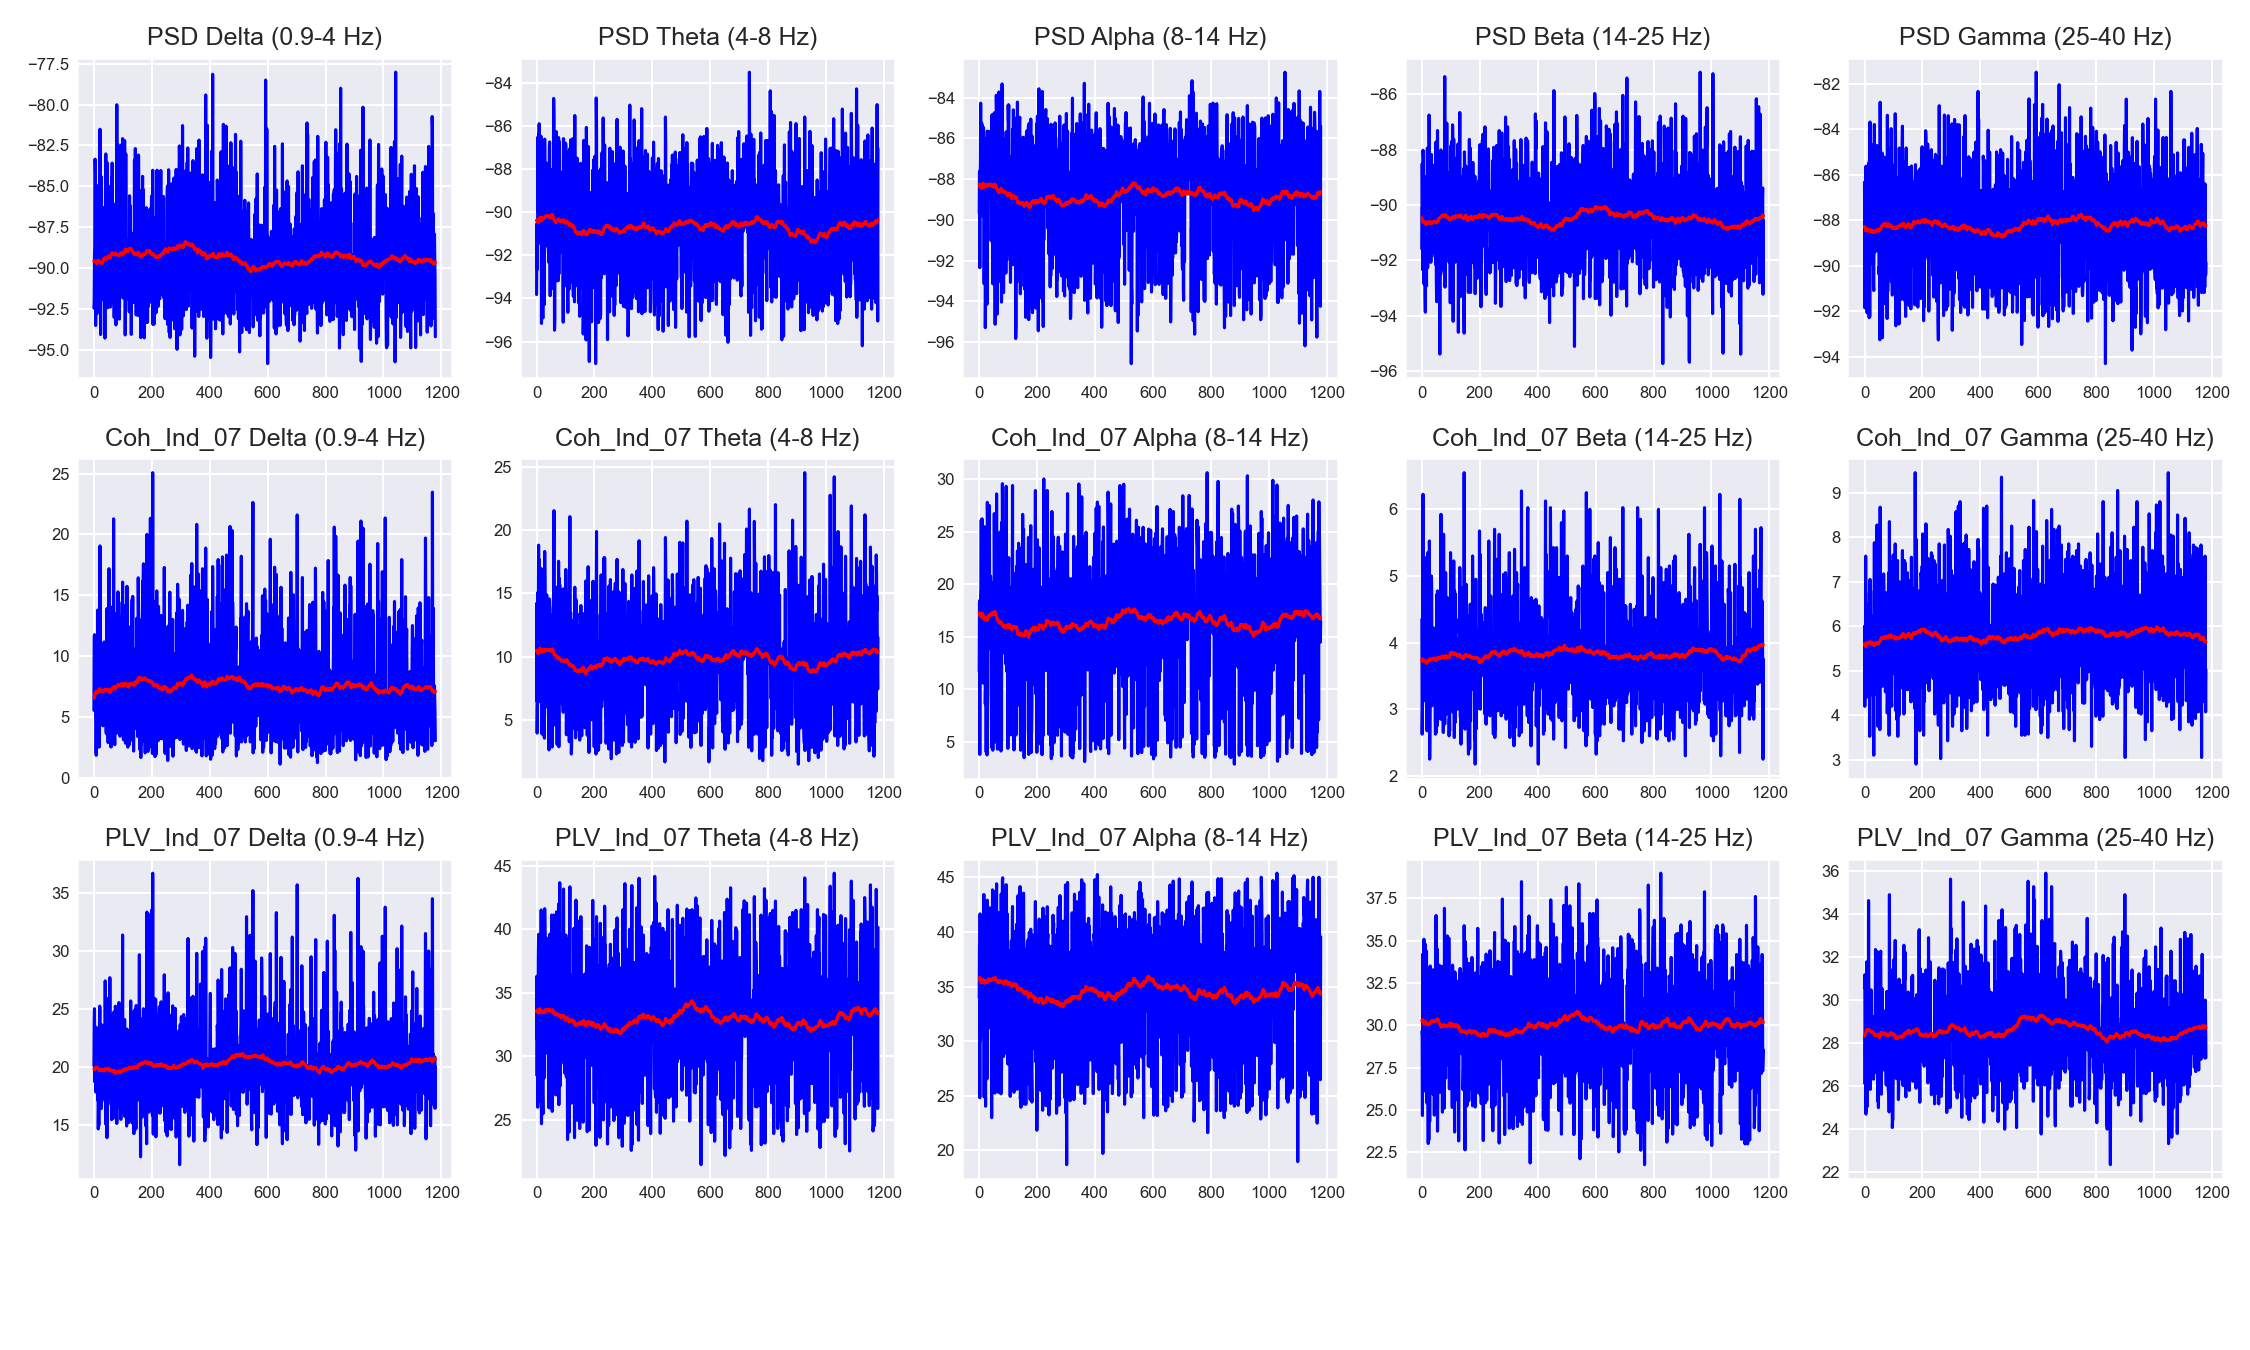

In [106]:
# Plotting overall PSD, Coherence and PLV with stage bounds

ind_rate = '07'

# Features DataFrames
df_ft_psd = df_ft_psd_all_db_surr.copy()
df_cols = [col for col in df_ft_coh_ind_all_surr.columns if (ind_rate in col)]
df_ft_coh = df_ft_coh_ind_all_surr[df_cols].copy()
df_cols = [col for col in df_ft_plv_ind_all_surr.columns if (ind_rate in col)]
df_ft_plv = df_ft_plv_ind_all_surr[df_cols].copy()

# Initialize plots
n_cols = n_freq
n_rows = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
plt.subplots_adjust(left=0.02)

_d = 50 # half-interval for calculating mean and std

# PSD plots (1st row)
for i in range(n_freq):
    y_mean = np.zeros(n_samples)
    for _s in range(n_samples):
        y_mean[_s] = np.mean(df_ft_psd.to_numpy()[max(0, _s-_d):min(_s+_d, n_samples), i])
    
    y = df_ft_psd.to_numpy()[:,i]  
    axs[0,i].plot(y, color='blue')
    axs[0,i].plot(y_mean, color='red')
    axs[0,i].set_title("PSD "+ bands[i][2])
    axs[0,i].tick_params(axis='both', labelsize=8, direction='in')
       
# Coherence plots (2nd row)
for i in range(n_freq):
    y_mean = np.zeros(n_samples)
    for _s in range(n_samples):
        y_mean[_s] = np.mean(df_ft_coh.to_numpy()[max(0, _s-_d):min(_s+_d, n_samples), i])

    y = df_ft_coh.to_numpy()[:,i]
    axs[1,i].plot(y, color='blue')
    axs[1,i].plot(y_mean, color='red')
    axs[1,i].set_title('Coh_Ind_'+ind_rate+' '+bands[i][2])
    axs[1,i].tick_params(axis='both', labelsize=8, direction='in')
    
# PLV plots (3rd row)
for i in range(n_freq):
    y_mean = np.zeros(n_samples)
    for _s in range(n_samples):
        y_mean[_s] = np.mean(df_ft_plv.to_numpy()[max(0, _s-_d):min(_s+_d, n_samples), i])

    y = df_ft_plv.to_numpy()[:,i]
    axs[2,i].plot(y, color='blue')
    axs[2,i].plot(y_mean, color='red')
    axs[2,i].set_title('PLV_Ind_'+ind_rate+' '+bands[i][2])
    axs[2,i].tick_params(axis='both', labelsize=8, direction='in')
    
plt.tight_layout(rect=[0,0.09,1,1])


# Clusterization functions

In [20]:
# Функция для расчёта оценок качетва кластеризации
def cluster_metrics_noground(name, data, labels_pred):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])

    # Define the metrics which require only data and predicted labels
    cluster_metrics = [
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
        metrics.davies_bouldin_score
    ]
    results += [m(data, labels_pred) for m in cluster_metrics]

    df_data.loc[0] = results
    
    return df_data

In [21]:
def apply_cluster_method(data, cl_method, name, df_metrics, **kwargs):
    method = cl_method(**kwargs).fit(data)
    
    df = cluster_metrics_noground(name, data, method.labels_)
    df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    return method, df_metrics

In [22]:
# Calculating clustering noground metrics for adjacent pairs of stages (Silh, Cal-Har, Dav-Bold)
def calc_stage_metr_noground(df_features, st_edges):
    df_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
    
    for _st in range(1, len(st_edges)-1):
        name = 'St'+str(_st)+'_St'+str(_st+1)
        data = df_features.iloc[st_edges[_st-1]:st_edges[_st+1]].reset_index(drop=True)
        labels = [0 for i in range(st_edges[_st]-st_edges[_st-1])] + [1 for i in range(st_edges[_st+1]-st_edges[_st])]
        
        df = cq.cluster_metrics_noground(name, data, labels)
        df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    df_metrics.rename(columns={'Method': 'Stages'}, inplace=True)

    return df_metrics


In [23]:
# Матрица связности для k соседних по времени эпох
#K_NEIGHBORS = 30

def knn_con_matr(X):
    n_samples = len(X)
    sm = sp.sparse.lil_matrix((n_samples, n_samples), dtype=np.int8)
    for i in range(n_samples):
        for j in range(n_samples):
            if abs(i-j)<=k_neighbours: sm[i,j]=1
    return sm.tocsr()


## Clustering process

### Main data

In [67]:
display(df_ft_psd_loc_db_sc.describe())
display(df_ft_psd_ind_loc_sc.describe())
display(df_ft_coh_ind_loc_sc.describe())
display(df_ft_plv_ind_loc_sc.describe())

D_psd_Fp  D_psd_LF  D_psd_MF  D_psd_RF  D_psd_LT  D_psd_RT  D_psd_LC  \
count  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00   
mean      -0.00     -0.00     -0.00      0.00      0.00     -0.00     -0.00   
std        1.00      1.00      1.00      1.00      1.00      1.00      1.00   
min       -2.46     -2.06     -2.60     -2.20     -2.73     -2.31     -2.58   
25%       -0.72     -0.75     -0.74     -0.70     -0.71     -0.74     -0.70   
50%       -0.13     -0.19     -0.13     -0.14     -0.11     -0.15     -0.16   
75%        0.63      0.67      0.64      0.54      0.61      0.63      0.56   
max        5.64      3.73      3.70      4.29      3.63      3.81      3.04   

       D_psd_MC  D_psd_RC  D_psd_LP  ...  G_psd_RT  G_psd_LC  G_psd_MC  \
count  1,180.00  1,180.00  1,180.00  ...  1,180.00  1,180.00  1,180.00   
mean       0.00      0.00     -0.00  ...     -0.00     -0.00     -0.00   
std        1.00      1.00      1.00  ...      1.00      1.00      1.00   
min       -2.42     -2.55     -2.86  ...     -2.91     -2.48     -2.73   
25%       -0.72     -0.73     -0.70  ...     -0.48     -0.82     -0.78   
50%       -0.16     -0.09     -0.10  ...      0.02      0.05     -0.08   
75%        0.59      0.64      0.64  ...      0.53      0.77      0.76   
max        3.18      3.07      3.69  ...      5.69      3.02      3.03   

       G_psd_RC  G_psd_LP  G_psd_MP  G_psd_RP  G_psd_LO  G_psd_MO  G_psd_RO  
count  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  
mean      -0.00     -0.00     -0.00     -0.00     -0.00     -0.00      0.00  
std        1.00      1.00      1.00      1.00      1.00      1.00      1.00  
min       -2.07     -2.67     -3.31     -2.07     -2.82     -3.64     -2.64  
25%       -0.86     -0.79     -0.66     -0.84     -0.70     -0.63     -0.76  
50%       -0.01      0.03     -0.00     -0.11     -0.09     -0.03     -0.14  
75%        0.78      0.73      0.66      0.76      0.65      0.57      0.63  
max        5.49      2.89      3.24      2.90      3.32      5.31      3.64  

[8 rows x 75 columns]

T_D_psd_Fp  A_D_psd_Fp  A_T_psd_Fp  A_DT_psd_Fp  B_D_psd_Fp  \
count    1,180.00    1,180.00    1,180.00     1,180.00    1,180.00   
mean        -0.00       -0.00       -0.00         0.00       -0.00   
std          1.00        1.00        1.00         1.00        1.00   
min         -3.49       -4.61       -4.01        -5.78       -4.99   
25%         -0.70       -0.63       -0.65        -0.57       -0.64   
50%          0.11        0.07       -0.03         0.14        0.04   
75%          0.72        0.73        0.60         0.69        0.68   
max          2.55        2.26        3.80         2.64        3.52   

       B_T_psd_Fp  B_A_psd_Fp  B_DT_psd_Fp  B_TA_psd_Fp  G_D_psd_Fp  ...  \
count    1,180.00    1,180.00     1,180.00     1,180.00    1,180.00  ...   
mean         0.00        0.00        -0.00        -0.00        0.00  ...   
std          1.00        1.00         1.00         1.00        1.00  ...   
min         -3.73       -3.41        -5.64        -3.78       -4.67  ...   
25%         -0.69       -0.70        -0.63        -0.68       -0.66  ...   
50%          0.04       -0.00         0.04         0.06        0.03  ...   
75%          0.69        0.70         0.70         0.72        0.71  ...   
max          3.12        2.71         3.73         2.67        2.87  ...   

       B_A_psd_RO  B_DT_psd_RO  B_TA_psd_RO  G_D_psd_RO  G_T_psd_RO  \
count    1,180.00     1,180.00     1,180.00    1,180.00    1,180.00   
mean         0.00        -0.00         0.00       -0.00        0.00   
std          1.00         1.00         1.00        1.00        1.00   
min         -2.06        -3.30        -2.28       -3.08       -2.33   
25%         -0.75        -0.64        -0.78       -0.69       -0.78   
50%         -0.24        -0.01        -0.17       -0.00       -0.09   
75%          0.64         0.64         0.69        0.69        0.73   
max          2.74         2.85         2.77        3.30        3.29   

       G_A_psd_RO  G_B_psd_RO  G_DT_psd_RO  G_TA_psd_RO  G_AB_psd_RO  
count    1,180.00    1,180.00     1,180.00     1,180.00     1,180.00  
mean        -0.00        0.00        -0.00        -0.00         0.00  
std          1.00        1.00         1.00         1.00         1.00  
min         -1.87       -3.23        -2.79        -2.10        -2.05  
25%         -0.77       -0.76        -0.71        -0.78        -0.78  
50%         -0.24        0.01        -0.10        -0.18        -0.18  
75%          0.66        0.70         0.62         0.75         0.76  
max          2.87        2.76         3.02         2.87         2.63  

[8 rows x 240 columns]

D_coh_Fp_06  D_coh_Fp_07  D_coh_Fp_08  D_coh_LF_06  D_coh_LF_07  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00        -0.00         0.00        -0.00         0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -1.63        -1.16        -0.81        -1.85        -1.38   
25%          -0.80        -0.66        -0.47        -0.75        -0.73   
50%          -0.16        -0.29        -0.30        -0.23        -0.28   
75%           0.55         0.40         0.21         0.65         0.52   
max           4.20         4.72         5.84         3.62         4.35   

       D_coh_LF_08  D_coh_MF_06  D_coh_MF_07  D_coh_MF_08  D_coh_RF_06  ...  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  ...   
mean          0.00        -0.00         0.00        -0.00         0.00  ...   
std           1.00         1.00         1.00         1.00         1.00  ...   
min          -1.03        -2.16        -1.56        -1.06        -1.45  ...   
25%          -0.67        -0.73        -0.76        -0.69        -0.67  ...   
50%          -0.30        -0.09        -0.22        -0.31        -0.25  ...   
75%           0.35         0.63         0.67         0.44         0.34  ...   
max           5.70         3.18         3.71         5.19         4.75  ...   

       G_coh_RP_08  G_coh_LO_06  G_coh_LO_07  G_coh_LO_08  G_coh_MO_06  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00         0.00         0.00        -0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -2.19        -2.67        -2.47        -1.68        -4.11   
25%          -0.88        -0.76        -0.33        -0.42         0.06   
50%           0.11        -0.04        -0.02        -0.42         0.06   
75%           1.09         0.67         0.59         1.25         0.48   
max           3.05         3.78         3.65         3.77         4.23   

       G_coh_MO_07  G_coh_MO_08  G_coh_RO_06  G_coh_RO_07  G_coh_RO_08  
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  
mean         -0.00        -0.00        -0.00        -0.00         0.00  
std           1.00         1.00         1.00         1.00         1.00  
min          -2.50        -3.37        -1.66        -1.96        -1.67  
25%          -0.94        -0.89        -0.68        -0.34        -0.24  
50%          -0.15        -0.06        -0.19        -0.34        -0.24  
75%           0.89         0.77         0.55         0.31         0.23  
max           1.94         4.91         3.98         4.20         5.47  

[8 rows x 225 columns]

D_plv_Fp_06  D_plv_Fp_07  D_plv_Fp_08  D_plv_LF_06  D_plv_LF_07  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00        -0.00         0.00         0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -3.52        -3.22        -2.75        -3.20        -2.53   
25%          -0.67        -0.67        -0.63        -0.72        -0.72   
50%          -0.05        -0.12        -0.14        -0.02        -0.08   
75%           0.64         0.57         0.51         0.62         0.56   
max           3.55         4.02         4.52         3.36         3.71   

       D_plv_LF_08  D_plv_MF_06  D_plv_MF_07  D_plv_MF_08  D_plv_RF_06  ...  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  ...   
mean          0.00        -0.00         0.00         0.00         0.00  ...   
std           1.00         1.00         1.00         1.00         1.00  ...   
min          -2.34        -3.34        -3.02        -2.59        -2.47  ...   
25%          -0.73        -0.63        -0.70        -0.72        -0.73  ...   
50%          -0.10        -0.09        -0.00        -0.03        -0.08  ...   
75%           0.53         0.67         0.60         0.56         0.57  ...   
max           4.08         2.94         3.12         3.41         3.39  ...   

       G_plv_RP_08  G_plv_LO_06  G_plv_LO_07  G_plv_LO_08  G_plv_MO_06  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00         0.00         0.00         0.00         0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -3.00        -2.94        -2.63        -2.40        -2.81   
25%          -0.71        -0.71        -0.69        -0.67        -0.76   
50%          -0.01        -0.00        -0.08        -0.02        -0.02   
75%           0.70         0.71         0.63         0.63         0.72   
max           2.63         3.14         3.49         3.77         2.95   

       G_plv_MO_07  G_plv_MO_08  G_plv_RO_06  G_plv_RO_07  G_plv_RO_08  
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  
mean         -0.00        -0.00        -0.00        -0.00        -0.00  
std           1.00         1.00         1.00         1.00         1.00  
min          -2.47        -2.22        -2.85        -2.45        -2.27  
25%          -0.73        -0.79        -0.72        -0.62        -0.67  
50%          -0.08        -0.12        -0.03        -0.09        -0.06  
75%           0.65         0.65         0.65         0.54         0.54  
max           3.31         4.19         3.04         3.41         3.85  

[8 rows x 225 columns]

In [24]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis=1)
#df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc], axis=1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)
#df_ft_tot_pca = pd.DataFrame(ft_tot_pca[:-2], columns=pca_comp_names) # for m8 (artifacts at the end)
n_samples = len(df_ft_tot_pca)
print(n_samples, df_ft_tot_pca.to_numpy().shape)

(1046, 15)
Explained variance 0.71
[0.211, 0.156, 0.069, 0.063, 0.046, 0.032, 0.026, 0.02, 0.018, 0.015, 0.013, 0.012, 0.01, 0.009, 0.009]
765
1046
1046 (1046, 15)


In [ ]:
# Iterative automatic process of finding best clusterisation 

# Global variables
k_neighb_min = 20
k_neighb_max = 50
n_cl_min = 2
n_cl_max = 20

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process

st_dist_rate = 0.3

#min_stage_length = 40 # minimum acceptable stage length

# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))

df_best_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges = pd.DataFrame(columns=['Len_min', 'N_clusters', 'K_neighb', 'Silh', 'St_edges'])

for n_clusters in range(n_cl_min, n_cl_max+1):
    for k_neighbours in range(k_neighb_min, k_neighb_max+1):
        # Clustering, Ward method        
        cl_name = 'ward_pca_'+str(n_clusters)+'_'+str(k_neighbours)
        cl_method, df_best_metrics = apply_cluster_method(data=df_features, cl_method=AgglomerativeClustering, 
                                                          name=cl_name, df_metrics=df_best_metrics, n_clusters=n_clusters, 
                                                          linkage='ward', connectivity=knn_con_matr)
        # Forming stages from clusters
        st_edges = spr.form_stages(cl_method.labels_)
        
        # Merging stages
        for st_len_min in len_st_thr:
            st_edges = spr.merge_stages_1st_step(df_features, st_edges, len_threshold=st_len_min) 
            st_edges = spr.merge_stages_2nd_step(df_features, st_edges, dist_threshold=st_dist_rate) 
            # Insert clusterization results into DataFrame
            silh_metric = df_best_metrics[df_best_metrics['Method']==cl_name].iloc[0]['Silh']
            new_row = {'Len_min': st_len_min, 'N_clusters': n_clusters, 'K_neighb': k_neighbours, 
                                       'Silh': silh_metric, 'St_edges': st_edges}
            df_st_edges = df_st_edges.append(new_row, ignore_index = True)
            # Print results
            st_lengths = np.array([st_edges[i+1] - st_edges[i] for i in range(len(st_edges)-1)])
            print(st_len_min, n_clusters, k_neighbours, len(st_lengths), st_edges, st_lengths)

display(df_best_metrics)
display(df_st_edges)

In [ ]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#stage_length_threshold = 60
#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']
n_st_edge_max = 15 # max number of resulting edge clusters

df_features = df_ft_tot_pca

df_st_edge_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_result = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all = []
            st_edges_list = []
            st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                              (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all += _st_edges[1:-1].tolist()
            st_edges_all = sorted(st_edges_all)
            print(st_len, k_nb_max, n_cl, len(st_edges_all))
            df_st_edges_all = pd.DataFrame(st_edges_all)
            
            # Clustering stage edges            
            for n_st_edge_clusters in range(2, n_st_edge_max+1):
                cl_name = ('kmeans_edges_'+str(n_st_edge_clusters)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                                                 name=cl_name, df_metrics=df_st_edge_metrics, 
                                                                                 n_clusters=n_st_edge_clusters, random_state=0)
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode[0])
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    #st_edges_result = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    st_bands, new_labels = spr.form_stage_bands(st_edges_centers[_cen])
                    n_stages = len(st_bands)
                
                    name = ('stages_'+cl_cen+'_'+str(n_st_edge_clusters+1)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                    
                    # Overall dataset clustering metrics for stages
                    df = cq.cluster_metrics_noground(name, df_features, new_labels)
                    df_stage_metrics = df_stage_metrics.drop(df_stage_metrics[df_stage_metrics['Method']==name].index, 
                                                             errors='ignore')
                    df_stage_metrics = pd.concat([df_stage_metrics, df], ignore_index=True)
                        
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_centers[_cen])
                    silh = df_adj_st_metr['Silh'].mean()
                    cal_har = df_adj_st_metr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                                'N_cl_max': n_cl, 'Cl_cen': cl_cen, 'Ward_dist': st_dist_w_avg[_cen], 
                                'Cen_dist': st_dist_c_avg[_cen], 'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold,
                                'St_edges': st_edges_centers[_cen]}
                    df_st_edges_result = df_st_edges_result.append(new_row, ignore_index = True)
                            
pd.set_option('display.max_rows', None)
display(df_st_edge_metrics)
display(df_stage_metrics)
display(df_st_edges_result)        


In [71]:
# Plot parameters for each number of stages

min_stage_length = 0 # minimum acceptable stage length

df_st_edges_best = pd.DataFrame(columns=df_st_edges_result.columns)

for n_st in range(3,n_st_edge_max+2):
    df = df_st_edges_result[(df_st_edges_result['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]
        
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best = df_st_edges_best.append(new_row, ignore_index = True)
    
display(df_st_edges_best)

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
0         3          0       40       20    med  81,415.77     20.02  0.19   
1         4         60       40       20    med  46,085.07     17.21  0.15   
2         5         40       50       10    med  26,231.48     14.68  0.12   
3         6          0       50       10    med  21,522.91     14.94  0.11   
4         7         60       35       15   mode  17,135.17     13.53  0.10   
5         8         60       35       15   mode  11,994.93     12.55  0.09   
6         9         40       45       20   mode  11,702.92     13.51  0.10   
7        10         40       35       20   mode  11,873.56     14.72  0.11   
8        11          0       45       20   mode   9,412.36     14.47  0.11   
9        12          0       35       20   mode   8,389.00     14.20  0.10   
10       13         40       45       20    med   7,952.77     13.92  0.11   
11       14         40       45       20    med   7,178.93     13.36  0.11   
12       15         20       40       20   mode   6,512.44     13.14  0.10   
13       16         40       35       20    med   6,287.45     12.88  0.10   

    Cal-Har  Dav-Bold                                           St_edges  
0    194.83      2.02                                [0, 192, 822, 1180]  
1    120.37      2.29                           [0, 261, 622, 928, 1180]  
2     66.54      2.80                      [0, 192, 510, 690, 938, 1180]  
3     53.99      2.76                  [0, 13, 192, 488, 691, 960, 1180]  
4     45.55      2.99           [0, 133, 261, 458, 685, 938, 1037, 1180]  
5     33.53      3.15      [0, 133, 261, 458, 685, 827, 938, 1037, 1180]  
6     32.14      2.97  [0, 133, 261, 458, 685, 783, 928, 1045, 1126, ...  
7     32.80      2.66  [0, 83, 133, 261, 458, 685, 783, 938, 1037, 11...  
8     25.57      2.66  [0, 13, 133, 175, 261, 458, 670, 783, 938, 104...  
9     23.11      2.71  [0, 13, 133, 175, 314, 458, 633, 685, 827, 938...  
10    22.41      2.70  [0, 83, 133, 189, 261, 458, 510, 644, 745, 854...  
11    20.28      2.80  [0, 83, 133, 189, 261, 314, 458, 510, 644, 745...  
12    18.59      3.02  [0, 83, 133, 175, 261, 314, 458, 510, 622, 685...  
13    18.42      3.05  [0, 83, 133, 175, 261, 314, 381, 458, 510, 631...

mode
[0, 83, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180]


<IPython.core.display.Javascript object>


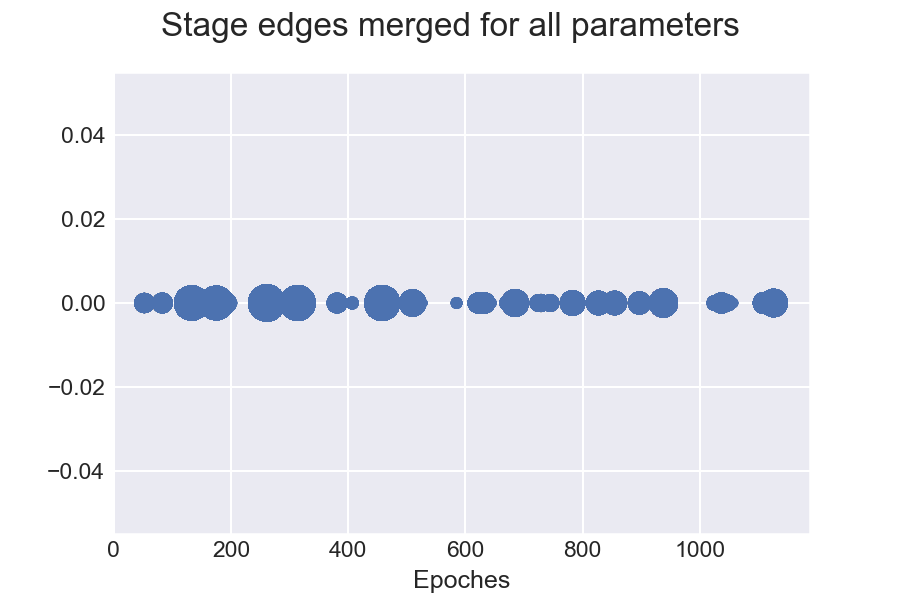

<IPython.core.display.Javascript object>


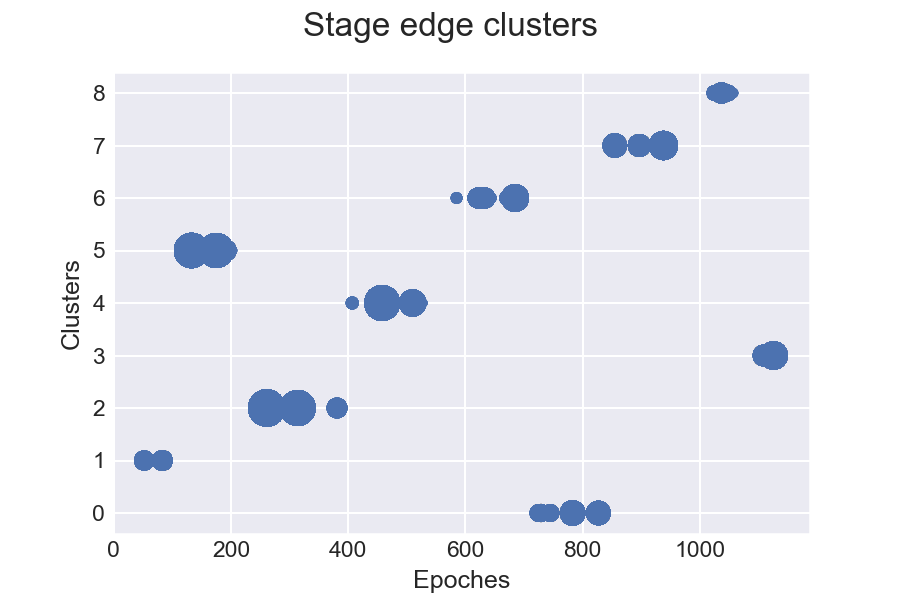

In [75]:
# Optimal number of clusters

n_stages = 10 # expert choise of result number of stages

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]
#st_len = 20
#k_nb = 45
#n_cl = 15

# Cluster center type
cl_center_type = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['Cl_cen'].iloc[0]
print(cl_center_type)

# Stage boundary epoch numbers
st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # results for m10
#st_edges_result = [0, 370, 526, 722, 1052, 1275, 1489, 1857, 2017] # results for m8
#st_edges_result = [0, 83, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180] # results for m3_2
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'kmeans_edges_'+str(n_stages-1)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            n_clusters=n_stages-1, random_state=0)
edg_labels_all = cluster_method.labels_
   
# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
plt.savefig(subj_dir_name+' Stage edges merged.png')

# Plotting clusters    
x = st_edges_all
y = edg_labels_all
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
plt.savefig(subj_dir_name+' Stage edge clusters.png')


In [76]:
# Find clustering statistic parameters (Main data)

df_st_edg_stats = pd.DataFrame(columns=['Cluster name', 'Median', 'Mean', 'Mode', 'Mode probability', 'Standard deviation', 
                                        'Median 0.95 confidence interval', 'Cluster size'])
st_clusters = []
for _st in range(n_stages-1):
    st_clusters.append([st_edges_all[i] for i in np.where(edg_labels_all == _st)[0]])
    mode, count = sp.stats.mode(st_clusters[_st])
    conf_int_median = spr.median_confidence_interval(pd.Series(st_clusters[_st]), cutoff=0.95)
    
    new_row = {'Cluster name': 'Boundary cluster '+str(_st), 'Median': int(np.median(st_clusters[_st])), 
               'Mean': int(np.array(st_clusters[_st]).mean()), 'Mode': mode[0], 
               'Mode probability': count[0]/len(st_clusters[_st]), 'Standard deviation': int(np.array(st_clusters[_st]).std()), 
               'Median 0.95 confidence interval': conf_int_median, 'Cluster size': len(st_clusters[_st])}
    df_st_edg_stats = df_st_edg_stats.append(new_row, ignore_index = True)

df_st_edg_stats = df_st_edg_stats.sort_values('Median', ignore_index=True)

df_name = subj_dir_name + ' df_st_edg_stats.xlsx'
print(df_name)
display(df_st_edg_stats)
df_st_edg_stats.to_excel(df_name)


m03_2 df_st_edg_stats.xlsx


Cluster name Median  Mean  Mode  Mode probability Standard deviation  \
0  Boundary cluster 1     83    69    83              0.48                 15   
1  Boundary cluster 5    175   162   133              0.36                 24   
2  Boundary cluster 2    314   297   261              0.44                 39   
3  Boundary cluster 4    458   477   458              0.50                 30   
4  Boundary cluster 6    633   645   685              0.27                 28   
5  Boundary cluster 0    745   768   783              0.24                 39   
6  Boundary cluster 7    897   902   938              0.35                 34   
7  Boundary cluster 8   1037  1039  1037              0.33                  8   
8  Boundary cluster 3   1126  1120  1126              0.55                  7   

  Median 0.95 confidence interval Cluster size  
0                        (52, 83)          111  
1                      (175, 175)          466  
2                      (268, 314)          427  
3                      (458, 458)          343  
4                      (632, 633)          377  
5                      (745, 783)          345  
6                      (897, 928)          317  
7                    (1037, 1037)          171  
8                    (1126, 1126)          193

In [77]:
# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

display(df_adj_st_metr)

Stages  Silh  Cal-Har  Dav-Bold  Centr      Ward
0   St1_St2  0.12    21.16      2.27  16.23  8,223.48
1   St2_St3  0.16    32.68      1.94  18.00 11,654.64
2   St3_St4  0.20    82.07      1.87  17.68 24,241.19
3   St4_St5  0.06    29.04      3.58   9.34  9,209.06
4   St5_St6  0.11    33.73      2.76  13.93 13,288.74
5   St6_St7  0.04    13.51      4.06  10.00  6,003.76
6   St7_St8  0.10    32.18      2.61  14.88 13,367.50
7   St8_St9  0.12    28.48      2.49  15.61 11,414.11
8  St9_St10  0.11    22.39      2.32  16.78  9,459.54

<IPython.core.display.Javascript object>


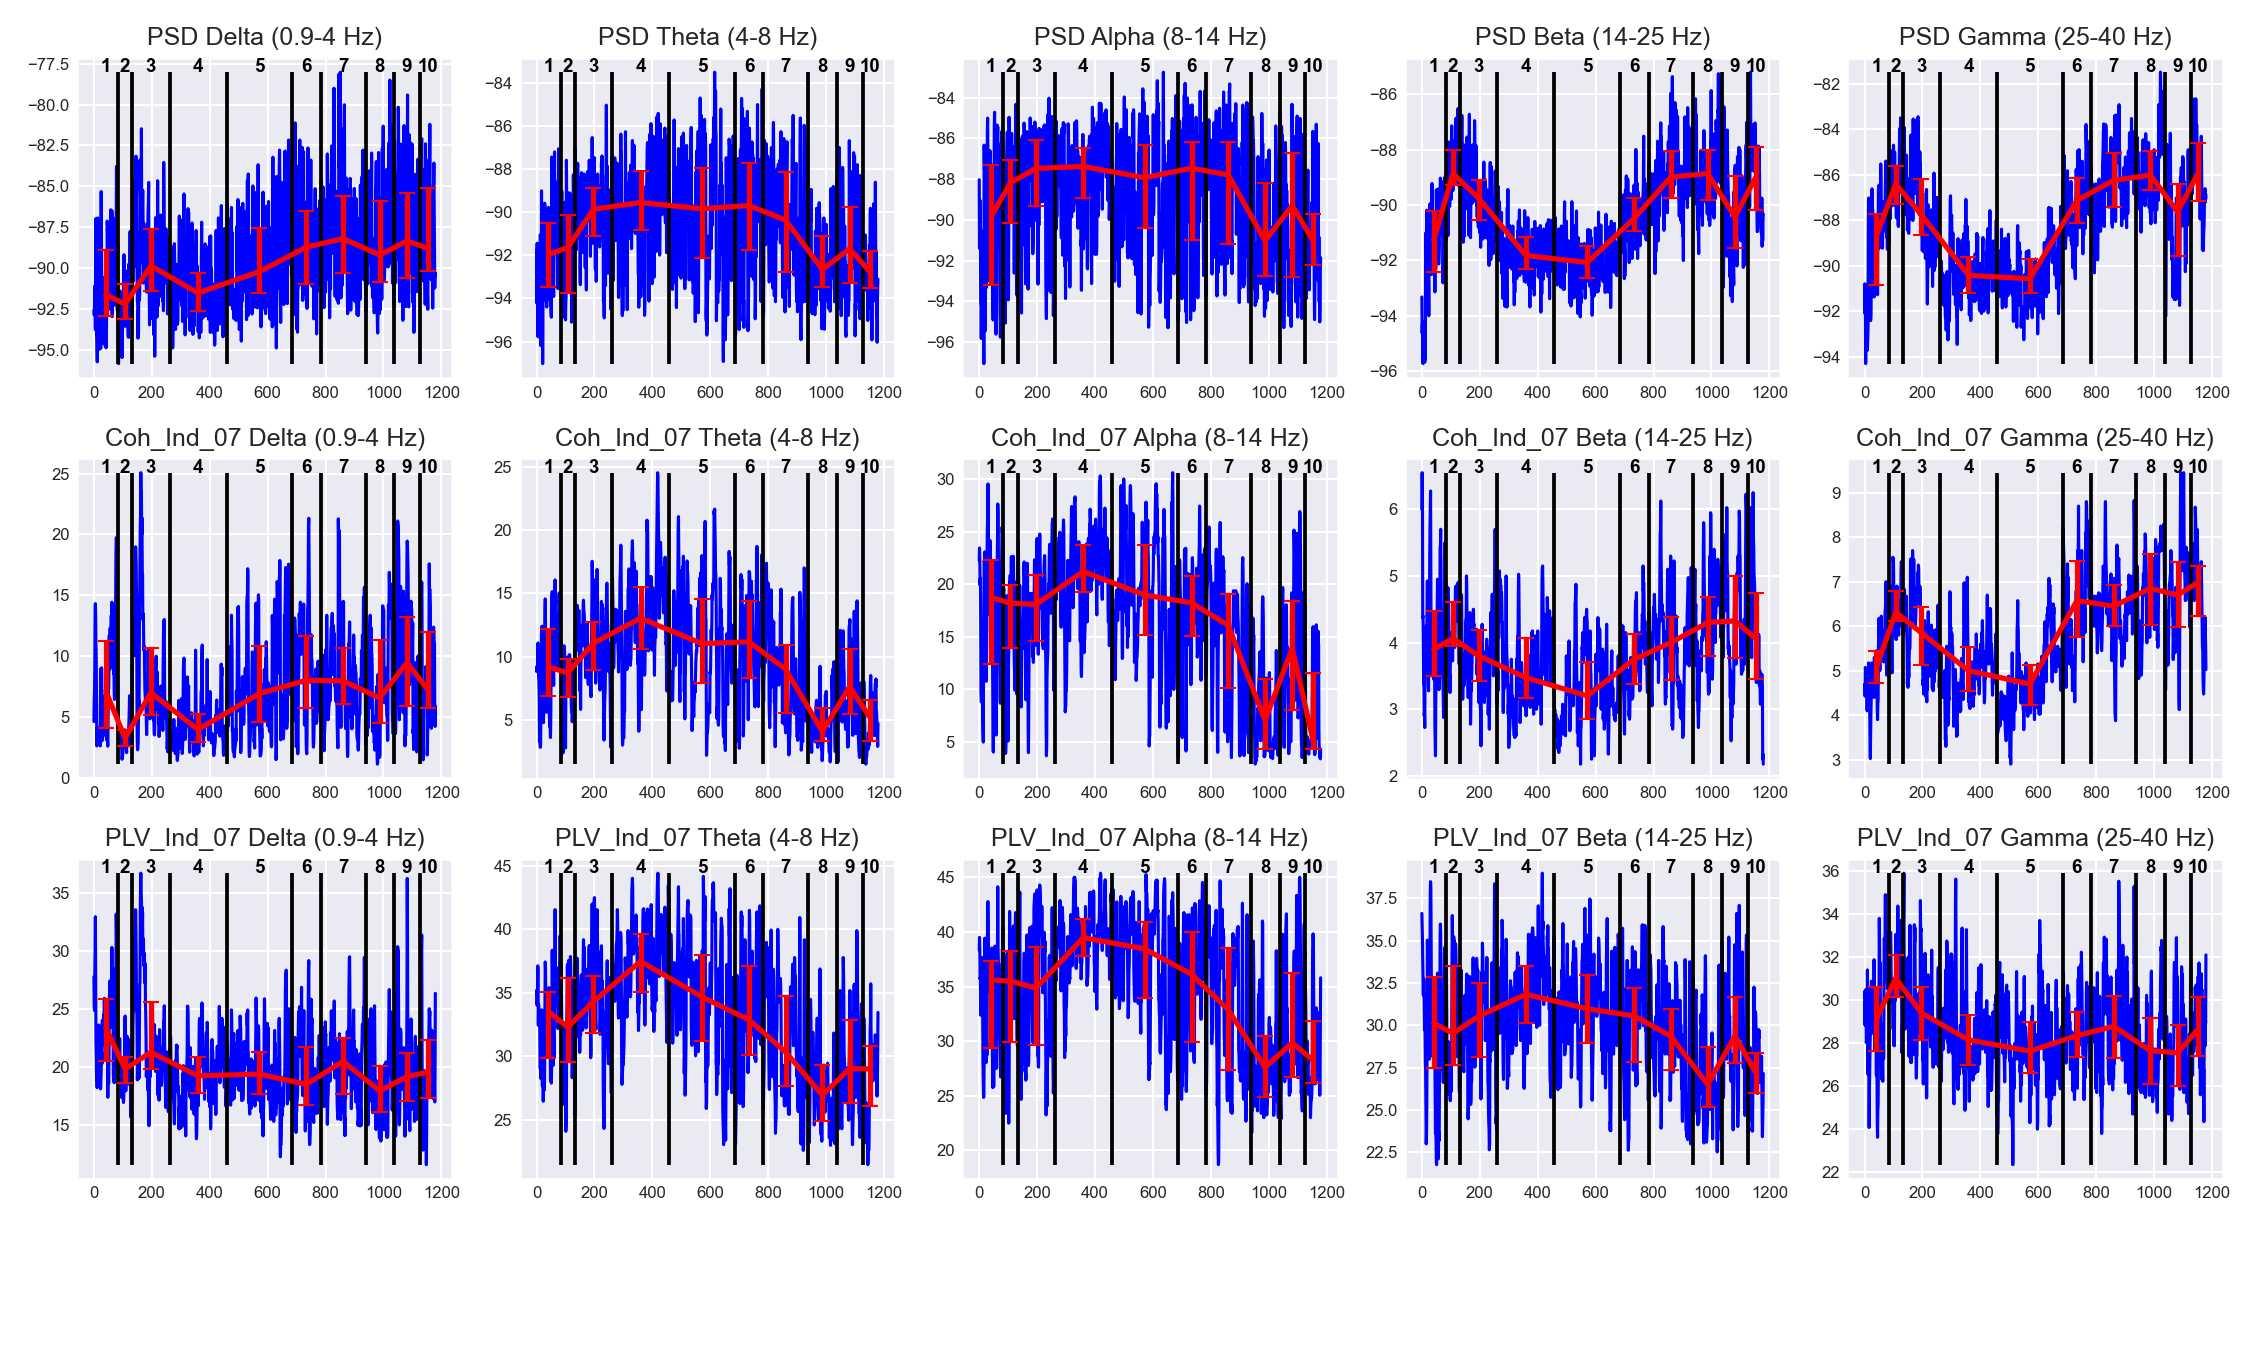

In [78]:
# Plotting overall PSD, Coherence and PLV with stage bounds

ind_rate = '07'

st_bands, st_labels = spr.form_stage_bands(st_edges_result)
x_st = [(smin + smax)/2 for (smin, smax, _) in st_bands]
#st_names = [st_nm for (_, _, st_nm) in st_bands]

# Features DataFrames
df_ft_psd = df_ft_psd_all_db
df_cols = [col for col in df_ft_coh_ind_all.columns if (ind_rate in col)]
df_ft_coh = df_ft_coh_ind_all[df_cols]
df_cols = [col for col in df_ft_plv_ind_all.columns if (ind_rate in col)]
df_ft_plv = df_ft_plv_ind_all[df_cols]

# Initialize plots
n_cols = n_freq
n_rows = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
plt.subplots_adjust(left=0.02)

# PSD plots (1st row)
df_ft_clust = [df_ft_psd.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_psd.to_numpy()[:,i]  
    axs[0,i].plot(y, color='blue')
    axs[0,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[0,i].set_title("PSD "+ bands[i][2])
    axs[0,i].tick_params(axis='both', labelsize=8, direction='in')
    
    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[0,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')
    
    # Add text (stage index)
    for _st in range(n_stages):
        axs[0,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')
    
# Coherence plots (2nd row)
df_ft_clust = [df_ft_coh.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_coh.to_numpy()[:,i]
    axs[1,i].plot(y, color='blue')
    axs[1,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[1,i].set_title('Coh_Ind_'+ind_rate+' '+bands[i][2])
    axs[1,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[1,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')   

    # Add text (stage index)
    for _st in range(n_stages):
        axs[1,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')   
    
# PLV plots (3rd row)
df_ft_clust = [df_ft_plv.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_plv.to_numpy()[:,i]
    axs[2,i].plot(y, color='blue')
    axs[2,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[2,i].set_title('PLV_Ind_'+ind_rate+' '+bands[i][2])
    axs[2,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[2,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')       

    # Add text (stage index)
    for _st in range(n_stages):
        axs[2,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')   
    
plt.tight_layout(rect=[0,0.09,1,1])

#fig.suptitle('PSD in brain regions by spectrum')
plt.savefig(subj_dir_name + ' features in stages.png') 


# Surrogate data 

In [25]:
# PCA decomposition (Surrogate data)

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig_surr = pd.concat([df_ft_psd_loc_db_sc_surr, df_ft_psd_ind_loc_sc_surr, df_ft_coh_ind_loc_sc_surr, 
                                 df_ft_plv_ind_loc_sc_surr], axis=1)
#df_ft_tot_orig_surr = pd.concat([df_ft_psd_loc_db_sc_surr, df_ft_psd_ind_loc_sc_surr], axis=1)
n_features = len(df_ft_tot_orig_surr.columns)

pca_surr = decomposition.PCA(n_components=N_COMP)

ft_tot_pca_surr = pca_surr.fit_transform(df_ft_tot_orig_surr)
print(ft_tot_pca_surr.shape)
print('Explained variance', round(pca_surr.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca_surr.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca_surr[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples_surr)

df_ft_tot_pca_surr = pd.DataFrame()
df_ft_tot_pca_surr = pd.DataFrame(ft_tot_pca_surr, columns=pca_comp_names)


(1046, 15)
Explained variance 0.71
[0.211, 0.156, 0.069, 0.063, 0.046, 0.032, 0.026, 0.02, 0.018, 0.015, 0.013, 0.012, 0.01, 0.009, 0.009]
765
1046


In [ ]:
# Iterative automatic process of finding best clustering (Surrogate data)

# Global variables
k_neighb_min = 20
k_neighb_max = 50
n_cl_min = 2
n_cl_max = 20

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process

#n_stages = 8
st_dist_rate = 0.3

min_stage_length = 40 # minimum acceptable stage length

# Initialization
df_features_surr = df_ft_tot_pca_surr
print(len(df_features_surr.columns))

df_best_metrics_surr = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_surr = pd.DataFrame(columns=['Len_min', 'N_clusters', 'K_neighb', 'Silh', 'St_edges'])

for n_clusters in range(n_cl_min, n_cl_max+1):
    for k_neighbours in range(k_neighb_min, k_neighb_max+1):
        # Clustering, Ward method        
        cl_name = 'ward_pca_'+str(n_clusters)+'_'+str(k_neighbours)
        cl_method, df_best_metrics_surr = apply_cluster_method(data=df_features_surr, cl_method=AgglomerativeClustering, 
                                                          name=cl_name, df_metrics=df_best_metrics_surr, n_clusters=n_clusters, 
                                                          linkage='ward', connectivity=knn_con_matr)
        # Forming stages from clusters
        st_edges = spr.form_stages(cl_method.labels_)
        
        # Merging stages
        for st_len_min in len_st_thr:
            st_edges = spr.merge_stages_1st_step(df_features_surr, st_edges, len_threshold=st_len_min) 
            st_edges = spr.merge_stages_2nd_step(df_features_surr, st_edges, dist_threshold=st_dist_rate) 
            # Insert clusterization results into DataFrame
            silh_metric = df_best_metrics_surr[df_best_metrics_surr['Method']==cl_name].iloc[0]['Silh']
            new_row = {'Len_min': st_len_min, 'N_clusters': n_clusters, 'K_neighb': k_neighbours, 
                                       'Silh': silh_metric, 'St_edges': st_edges}
            df_st_edges_surr = df_st_edges_surr.append(new_row, ignore_index = True)
            # Print results
            st_lengths = np.array([st_edges[i+1] - st_edges[i] for i in range(len(st_edges)-1)])
            print(st_len_min, n_clusters, k_neighbours, len(st_lengths), st_edges, st_lengths)

display(df_best_metrics_surr)
display(df_st_edges_surr)

In [ ]:
# Clustering stage edges (Surrogate data)

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#stage_length_threshold = 60
#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']
n_st_edge_max = 15

df_features_surr = df_ft_tot_pca_surr

df_st_edge_metr_surr = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metr_surr = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_result_surr = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all_surr = []
            st_edges_list = []
            st_edges_list += (df_st_edges_surr[(df_st_edges_surr['Len_min']==st_len) & (df_st_edges_surr['K_neighb']<=k_nb_max) 
                                               & (df_st_edges_surr['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all_surr += _st_edges[1:-1].tolist()
            st_edges_all_surr = sorted(st_edges_all_surr)
            print(st_len, k_nb_max, n_cl, len(st_edges_all_surr))
            df_st_edges_all_surr = pd.DataFrame(st_edges_all_surr)
            
            # Clustering stage edges            
            for n_st_edge_clusters in range(2, n_st_edge_max+1):
                cl_name = ('kmeans_edges_'+str(n_st_edge_clusters)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                cluster_method, df_st_edge_metr_surr = cq.apply_cluster_method(data=df_st_edges_all_surr, cl_method=KMeans, 
                                                                                 name=cl_name, df_metrics=df_st_edge_metr_surr, 
                                                                                 n_clusters=n_st_edge_clusters, random_state=0)
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all_surr[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode[0])
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples_surr])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples_surr])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples_surr])
                        
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features_surr, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    st_edges_result_surr = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    st_bands_surr, new_labels_surr = spr.form_stage_bands(st_edges_result_surr)
                    n_stages_surr = len(st_bands_surr)
                
                    name = ('stages_'+cl_cen+'_'+str(n_st_edge_clusters+1)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                    
                    # Overall dataset clustering metrics for stages
                    df = cq.cluster_metrics_noground(name, df_features_surr, new_labels_surr)
                    df_stage_metr_surr = df_stage_metr_surr.drop(df_stage_metr_surr[df_stage_metr_surr['Method']==name].index, 
                                                             errors='ignore')
                    df_stage_metr_surr = pd.concat([df_stage_metr_surr, df], ignore_index=True)
                        
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr_surr = calc_stage_metr_noground(df_features_surr, st_edges_result_surr)
                    silh = df_adj_st_metr_surr['Silh'].mean()
                    cal_har = df_adj_st_metr_surr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr_surr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                                'N_cl_max': n_cl, 'Cl_cen': cl_cen, 'Ward_dist': st_dist_w_avg[_cen], 
                                'Cen_dist': st_dist_c_avg[_cen], 'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold,
                                'St_edges': st_edges_result_surr}
                    df_st_edges_result_surr = df_st_edges_result_surr.append(new_row, ignore_index = True)
                            
pd.set_option('display.max_rows', None)
display(df_st_edge_metr_surr)
display(df_stage_metr_surr)
display(df_st_edges_result_surr)        


In [110]:
# Plot parameters for each number of stages (Surrogate data)

min_stage_length = 60 # minimum acceptable stage length

df_st_edges_best_surr = pd.DataFrame(columns=df_st_edges_result_surr.columns)

for n_st in range(3,n_st_edge_max+2):
    df = df_st_edges_result_surr[(df_st_edges_result_surr['N_stages']==n_st) & 
                                 (df_st_edges_result_surr['St_len_min']>=min_stage_length)]
        
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best_surr = df_st_edges_best_surr.append(new_row, ignore_index = True)
    
display(df_st_edges_best_surr)

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
0         3         60       45       20    med     811.24      1.99  0.00   
1         4         60       40       15    med   1,068.69      2.57  0.00   
2         5         60       45       15   mode   1,300.68      3.74  0.01   
3         6         60       45       15   mode   1,357.63      3.98  0.01   
4         7         60       45       15   mode   1,149.82      3.87  0.01   
5         8         60       50       15   mode     964.77      3.77  0.00   
6         9         60       50       15   mode     854.56      3.62  0.00   
7        10         60       40       20   mode     941.72      3.94  0.00   
8        11         60       40       20   mode     885.36      4.11  0.00   
9        12         60       40       10   mode     674.91      4.08  0.00   
10       13         60       45       10   mode     704.25      4.40  0.00   
11       14         60       35       20    med     744.07      4.38  0.00   
12       15         60       35       20   mode     686.63      4.56  0.01   
13       16         60       35       20   mode     837.66      5.22  0.00   

    Cal-Har  Dav-Bold                                           St_edges  
0      1.48     23.05                                [0, 349, 826, 1180]  
1      1.95     18.98                           [0, 223, 512, 826, 1180]  
2      2.35     12.38                       [0, 83, 532, 826, 930, 1180]  
3      2.46     11.77                  [0, 83, 322, 532, 826, 930, 1180]  
4      2.08     12.02             [0, 83, 322, 532, 732, 826, 930, 1180]  
5      1.75     12.83        [0, 83, 322, 429, 532, 697, 826, 930, 1180]  
6      1.55     13.72   [0, 83, 223, 322, 429, 532, 697, 826, 930, 1180]  
7      1.72     12.35  [0, 83, 204, 322, 481, 583, 702, 826, 930, 101...  
8      1.61     11.51  [0, 83, 204, 274, 322, 481, 583, 702, 826, 930...  
9      1.24     12.82  [0, 83, 223, 322, 429, 532, 583, 732, 826, 930...  
10     1.29     11.28  [0, 83, 223, 274, 322, 429, 532, 583, 732, 826...  
11     1.36     11.23  [0, 83, 204, 286, 324, 419, 481, 534, 583, 709...  
12     1.26     10.76  [0, 83, 204, 286, 322, 429, 481, 532, 583, 732...  
13     1.55      9.51  [0, 83, 204, 286, 322, 429, 481, 532, 583, 702...

mode
[0, 83, 204, 322, 481, 583, 702, 826, 930, 1012, 1180]


<IPython.core.display.Javascript object>


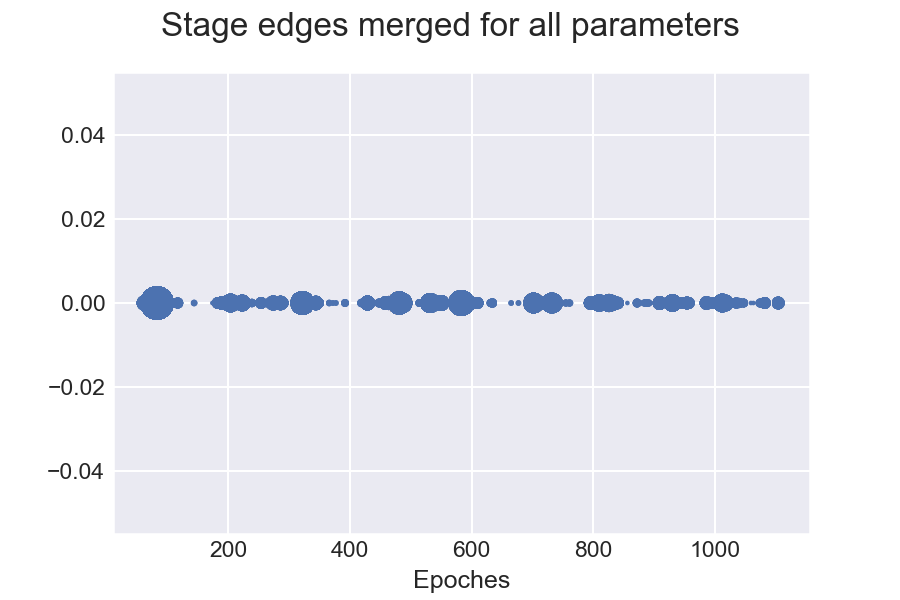

<IPython.core.display.Javascript object>


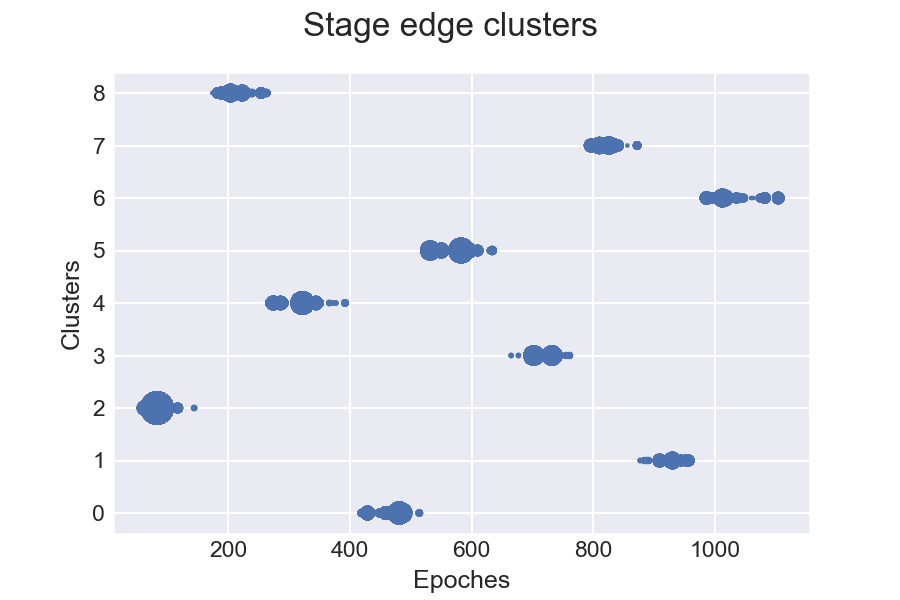

In [111]:
# Optimal number of clusters (Surrogate data)  

n_stages_surr = 10 # expert choise of result number of stages

st_len = df_st_edges_best_surr[df_st_edges_best_surr['N_stages']==n_stages_surr]['St_len_min'].iloc[0]
k_nb = df_st_edges_best_surr[df_st_edges_best_surr['N_stages']==n_stages_surr]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best_surr[df_st_edges_best_surr['N_stages']==n_stages_surr]['N_cl_max'].iloc[0]

# Cluster center type
cl_center_type_surr = df_st_edges_best_surr[df_st_edges_best_surr['N_stages']==n_stages_surr]['Cl_cen'].iloc[0]
print(cl_center_type_surr)

# Stage boundary epoch numbers
st_edges_result_surr = df_st_edges_best_surr[df_st_edges_best_surr['N_stages']==n_stages_surr]['St_edges'].iloc[0]
#st_edges_result_surr = [0, 74, 176, 296, 417, 558, 652, 767, 879, 1046] # for m10_surr
#st_edges_result_surr = [0, 219, 500, 745, 982, 1189, 1497, 1782, 2017] # for m8_surr
#st_edges_result_surr = [0, 83, 204, 322, 481, 583, 702, 826, 930, 1012, 1180] # for m3_surr
print(st_edges_result_surr)

st_edges_all_surr = []
st_edges_list = []
st_edges_list += (df_st_edges_surr[(df_st_edges_surr['Len_min']==st_len) & (df_st_edges_surr['K_neighb']<=k_nb) &
                  (df_st_edges_surr['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all_surr += _st_edges[1:-1].tolist()
st_edges_all_surr = sorted(st_edges_all_surr)
df_st_edges_all_surr = pd.DataFrame(st_edges_all_surr)
#print(st_edges_all_surr)
            
# Clustering stage edges
cl_name = 'kmeans_edges_'+str(n_stages_surr-1)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method_surr, df_st_edge_metr_surr = cq.apply_cluster_method(data=df_st_edges_all_surr, cl_method=KMeans, 
                                                            name=cl_name, df_metrics=df_st_edge_metr_surr, 
                                                            n_clusters=n_stages_surr-1, random_state=0)
edg_labels_all_surr = cluster_method_surr.labels_
    
# Plotting st_edges_all
x = st_edges_all_surr
y = [0]*len(x)
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
plt.savefig(subj_dir_name_surr + ' Stage edges merged.png')

# Plotting clusters    
x = st_edges_all_surr
y = edg_labels_all_surr
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
plt.savefig(subj_dir_name_surr + ' Stage edges clusters.png')


In [112]:
# Find clustering statistic parameters (Main data)

df_st_edg_stats_surr = pd.DataFrame(columns=['Cluster name', 'Median', 'Mean', 'Mode', 'Mode probability', 'Standard deviation', 
                                        'Median 0.95 confidence interval', 'Cluster size'])
st_clusters = []
for _st in range(n_stages_surr-1):
    st_clusters.append([st_edges_all_surr[i] for i in np.where(edg_labels_all_surr == _st)[0]])
    mode, count = sp.stats.mode(st_clusters[_st])
    conf_int_median = spr.median_confidence_interval(pd.Series(st_clusters[_st]), cutoff=0.95)
    
    new_row = {'Cluster name': 'Boundary cluster '+str(_st), 'Median': int(np.median(st_clusters[_st])), 
               'Mean': int(np.array(st_clusters[_st]).mean()), 'Mode': mode[0], 
               'Mode probability': count[0]/len(st_clusters[_st]), 'Standard deviation': int(np.array(st_clusters[_st]).std()), 
               'Median 0.95 confidence interval': conf_int_median, 'Cluster size': len(st_clusters[_st])}
    df_st_edg_stats_surr = df_st_edg_stats_surr.append(new_row, ignore_index = True)

df_st_edg_stats_surr = df_st_edg_stats_surr.sort_values('Median', ignore_index=True)

df_name = subj_dir_name_surr + ' df_st_edg_stats.xlsx'
print(df_name)
display(df_st_edg_stats_surr)
df_st_edg_stats_surr.to_excel(df_name)


m03_2_surr df_st_edg_stats.xlsx


Cluster name Median  Mean  Mode  Mode probability Standard deviation  \
0  Boundary cluster 2     83    84    83              0.76                 14   
1  Boundary cluster 8    204   214   204              0.28                 23   
2  Boundary cluster 4    322   316   322              0.30                 28   
3  Boundary cluster 0    481   472   481              0.24                 19   
4  Boundary cluster 5    583   570   583              0.33                 29   
5  Boundary cluster 3    709   718   702              0.19                 17   
6  Boundary cluster 7    815   818   826              0.16                 17   
7  Boundary cluster 1    930   928   930              0.24                 20   
8  Boundary cluster 6   1014  1024  1012              0.18                 33   

  Median 0.95 confidence interval Cluster size  
0                        (83, 83)          197  
1                      (204, 223)          147  
2                      (322, 322)          244  
3                      (478, 481)          280  
4                      (583, 583)          256  
5                      (709, 726)          278  
6                      (810, 826)          240  
7                      (930, 931)          152  
8                    (1012, 1017)          232

In [113]:
# Surrogate data
df_adj_st_metr_surr = calc_stage_metr_noground(df_features_surr, st_edges_result_surr)
st_metr_silh_surr = df_adj_st_metr_surr['Silh'].to_numpy()
st_metr_calh_surr = df_adj_st_metr_surr['Cal-Har'].to_numpy()
st_metr_davb_surr = df_adj_st_metr_surr['Dav-Bold'].to_numpy()

st_dist_ward_surr, st_dist_centr_surr = spr.calc_stage_distances(df_features_surr, st_edges_result_surr)
df_adj_st_metr_surr['Centr'] = st_dist_centr_surr
df_adj_st_metr_surr['Ward'] = st_dist_ward_surr

display(df_adj_st_metr_surr)

Stages  Silh  Cal-Har  Dav-Bold  Centr     Ward
0   St1_St2  0.00     2.36      8.73   5.13 1,294.30
1   St2_St3 -0.00     0.52     20.57   2.22   295.18
2   St3_St4  0.00     1.61     12.53   3.66   909.44
3   St4_St5  0.00     3.30      8.28   5.32 1,759.78
4   St5_St6 -0.00     1.66     10.98   3.99   875.11
5   St6_St7  0.00     1.11     14.22   3.18   615.84
6   St7_St8  0.01     2.41      9.39   4.93 1,373.98
7   St8_St9 -0.01     0.66     16.00   2.84   368.94
8  St9_St10 -0.00     1.84     10.47   4.22   982.91

<IPython.core.display.Javascript object>


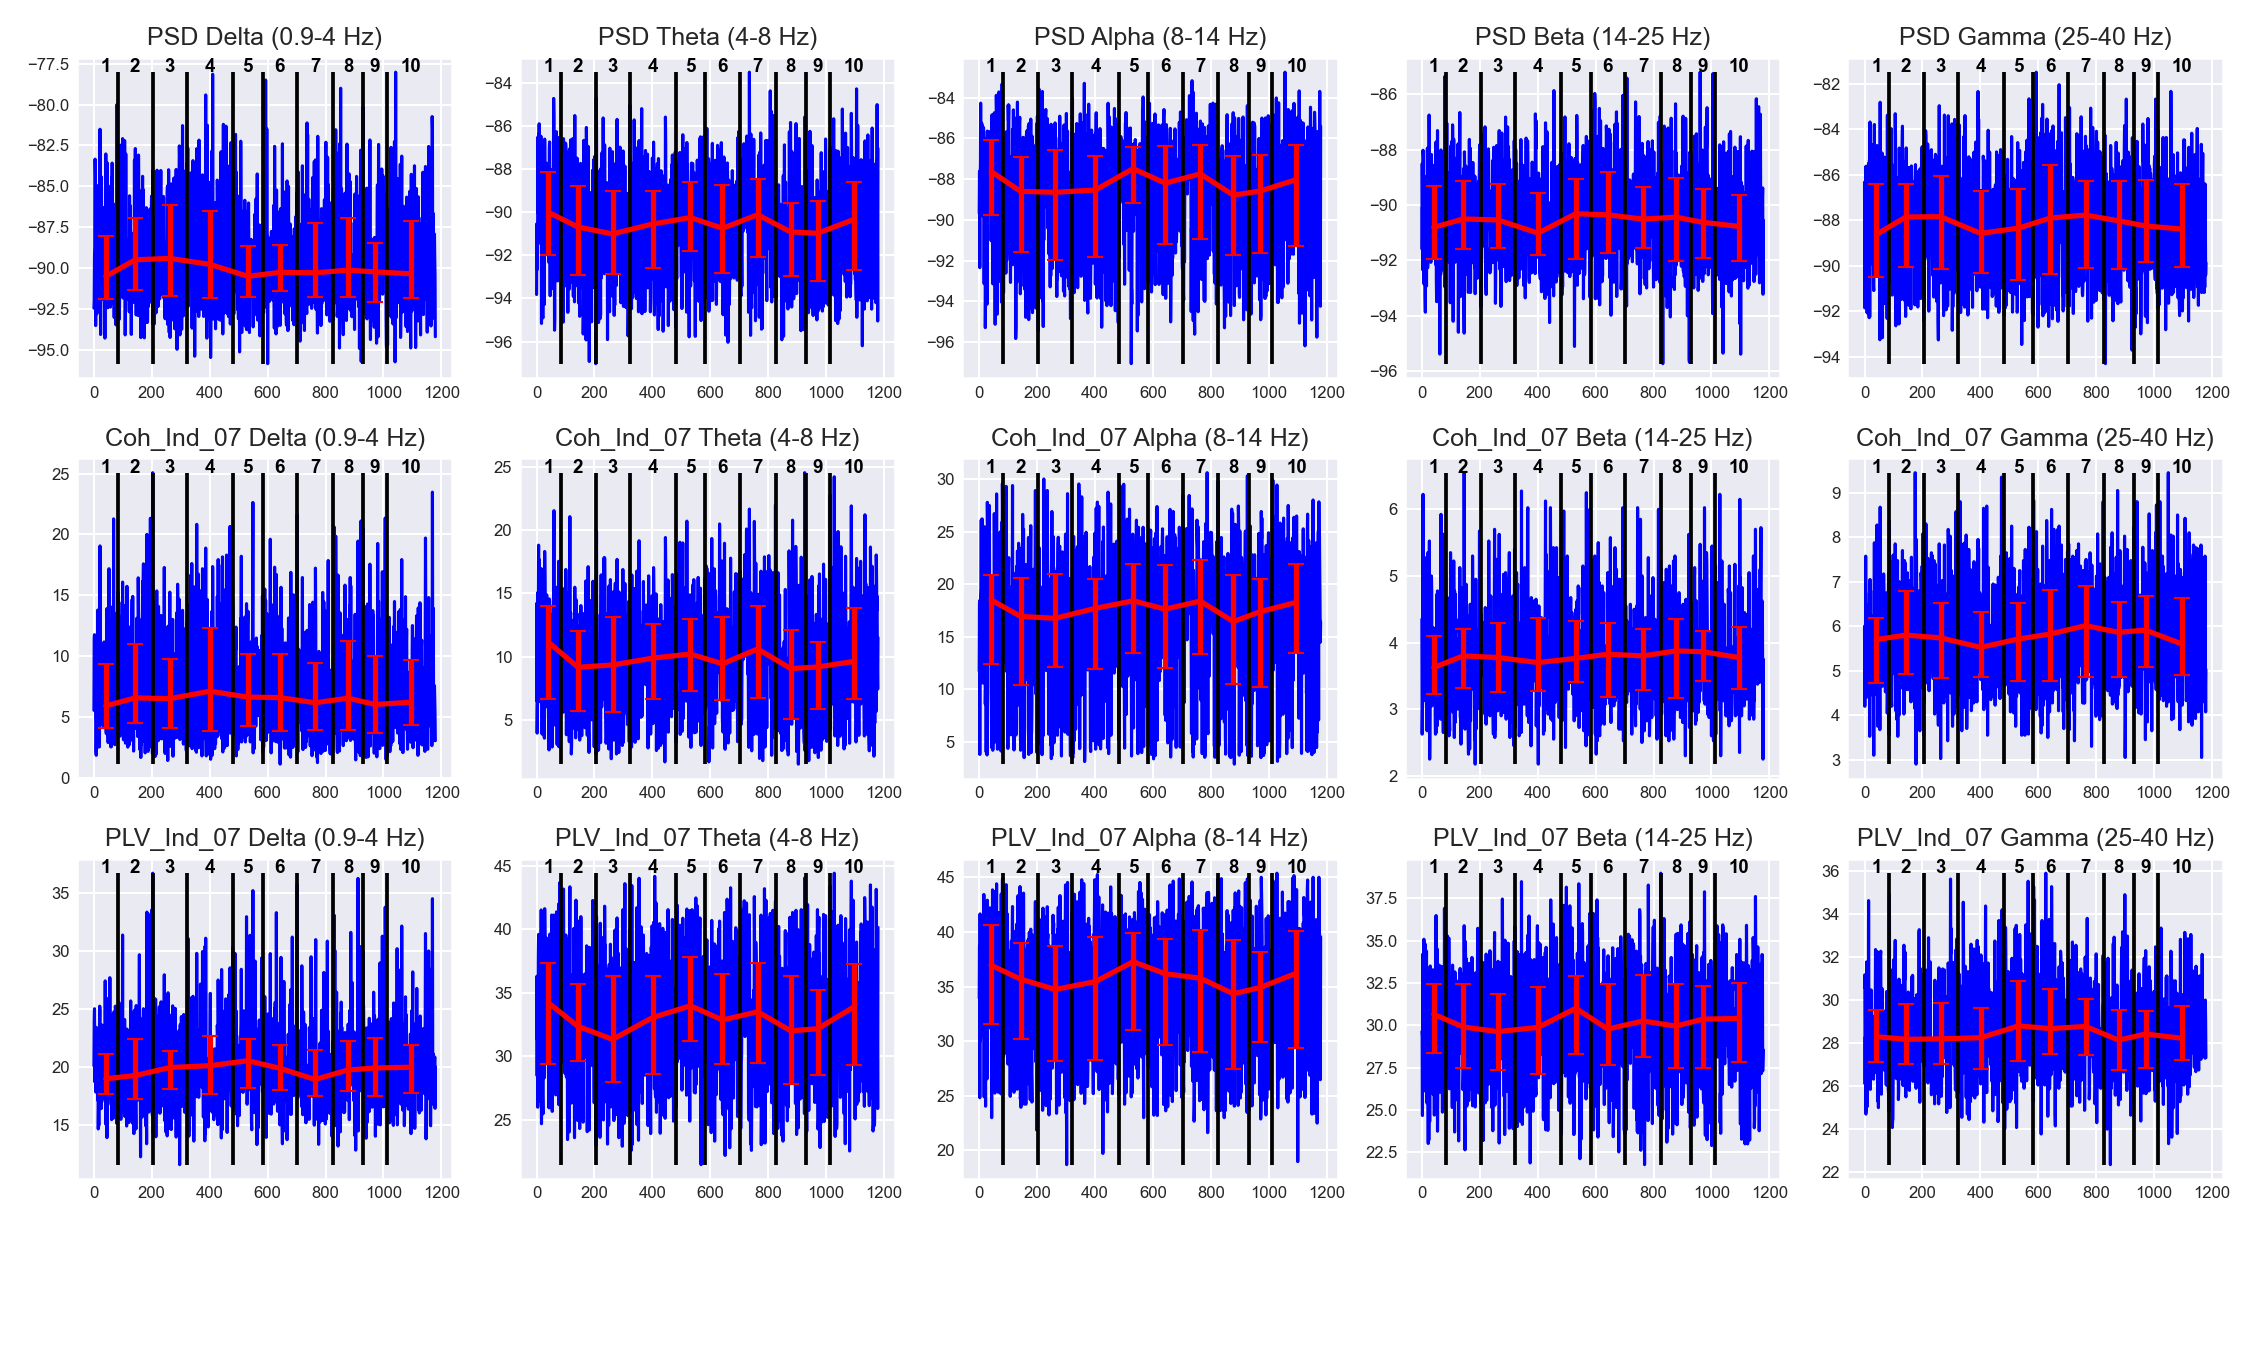

In [115]:
# Plotting overall PSD, Coherence and PLV with stage bounds

ind_rate = '07'

st_bands_surr, st_labels_surr = spr.form_stage_bands(st_edges_result_surr)
x_st = [(smin + smax)/2 for (smin, smax, _) in st_bands_surr]

# Features DataFrames
df_ft_psd = df_ft_psd_all_db_surr
df_cols = [col for col in df_ft_coh_ind_all_surr.columns if (ind_rate in col)]
df_ft_coh = df_ft_coh_ind_all_surr[df_cols]
df_cols = [col for col in df_ft_plv_ind_all_surr.columns if (ind_rate in col)]
df_ft_plv = df_ft_plv_ind_all_surr[df_cols]

# Initialize plots
n_cols = n_freq
n_rows = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
plt.subplots_adjust(left=0.02)

# PSD plots (1st row)
df_ft_clust = [df_ft_psd.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands_surr]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages_surr)]
for i in range(n_freq):
    y = df_ft_psd.to_numpy()[:,i]  
    axs[0,i].plot(y, color='blue')
    axs[0,i].vlines(x=st_edges_result_surr[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[0,i].set_title("PSD "+ bands[i][2])
    axs[0,i].tick_params(axis='both', labelsize=8, direction='in')
    
    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages_surr)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages_surr)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[0,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')

    # Add text (stage index)
    for _st in range(n_stages):
        axs[0,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')
    
# Coherence plots (2nd row)
df_ft_clust = [df_ft_coh.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands_surr]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages_surr)]
for i in range(n_freq):
    y = df_ft_coh.to_numpy()[:,i]
    axs[1,i].plot(y, color='blue')
    axs[1,i].vlines(x=st_edges_result_surr[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[1,i].set_title('Coh_Ind_'+ind_rate+' '+bands[i][2])
    axs[1,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages_surr)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages_surr)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[1,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')   

    # Add text (stage index)
    for _st in range(n_stages):
        axs[1,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')
    
# PLV plots (3rd row)
df_ft_clust = [df_ft_plv.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands_surr]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages_surr)]
for i in range(n_freq):
    y = df_ft_plv.to_numpy()[:,i]
    axs[2,i].plot(y, color='blue')
    axs[2,i].vlines(x=st_edges_result_surr[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[2,i].set_title('PLV_Ind_'+ind_rate+' '+bands[i][2])
    axs[2,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages_surr)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages_surr)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[2,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')       

    # Add text (stage index)
    for _st in range(n_stages):
        axs[2,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')
    
plt.tight_layout(rect=[0,0.09,1,1])

plt.savefig(subj_dir_name_surr + ' features in stages.png') 


# Results

In [59]:
# Load partition into stages

st_edges_result = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_result.txt'), dtype=int)
st_edges_result_surr = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_result_surr.txt'), dtype=int)
print(st_edges_result)
print(st_edges_result_surr)

# Form stage bands
st_bands, st_labels = spr.form_stage_bands(st_edges_result)
n_stages = len(st_bands)
st_bands_surr, st_labels_surr = spr.form_stage_bands(st_edges_result_surr)
n_stages_surr = len(st_bands_surr)


[   0   83  133  261  458  685  783  938 1037 1126 1180]
[   0   83  204  322  481  583  702  826  930 1012 1180]


In [60]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis=1)
#df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc], axis=1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)
#df_ft_tot_pca = pd.DataFrame(ft_tot_pca[:-2], columns=pca_comp_names) # for m8 (artifacts at the end)
n_samples = len(df_ft_tot_pca)
print(n_samples, df_ft_tot_pca.to_numpy().shape)

(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
765
1180
1180 (1180, 15)


In [61]:
# PCA decomposition (Surrogate data)

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig_surr = pd.concat([df_ft_psd_loc_db_sc_surr, df_ft_psd_ind_loc_sc_surr, df_ft_coh_ind_loc_sc_surr, 
                                 df_ft_plv_ind_loc_sc_surr], axis=1)
#df_ft_tot_orig_surr = pd.concat([df_ft_psd_loc_db_sc_surr, df_ft_psd_ind_loc_sc_surr], axis=1)
n_features = len(df_ft_tot_orig_surr.columns)

pca_surr = decomposition.PCA(n_components=N_COMP)

ft_tot_pca_surr = pca_surr.fit_transform(df_ft_tot_orig_surr)
print(ft_tot_pca_surr.shape)
print('Explained variance', round(pca_surr.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca_surr.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca_surr[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples_surr)

df_ft_tot_pca_surr = pd.DataFrame()
df_ft_tot_pca_surr = pd.DataFrame(ft_tot_pca_surr, columns=pca_comp_names)


(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
765
1046


In [62]:
# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))

df_features_surr = df_ft_tot_pca_surr
print(len(df_features_surr.columns))

15
15


In [63]:
# Calculate stage distances & clustering quality metrics

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Surrogate data
df_adj_st_metr_surr = calc_stage_metr_noground(df_features_surr, st_edges_result_surr)
st_metr_silh_surr = df_adj_st_metr_surr['Silh'].to_numpy()
st_metr_calh_surr = df_adj_st_metr_surr['Cal-Har'].to_numpy()
st_metr_davb_surr = df_adj_st_metr_surr['Dav-Bold'].to_numpy()

st_dist_ward_surr, st_dist_centr_surr = spr.calc_stage_distances(df_features_surr, st_edges_result_surr)
df_adj_st_metr_surr['Centr'] = st_dist_centr_surr
df_adj_st_metr_surr['Ward'] = st_dist_ward_surr


# Max distance values for plotting
st_dist_centr_max = np.max(np.concatenate((st_dist_centr, st_dist_centr_surr)))
st_dist_ward_max = np.max(np.concatenate((st_dist_ward, st_dist_ward_surr)))
st_metr_silh_max = np.max(np.concatenate((st_metr_silh, st_metr_silh_surr)))
st_metr_calh_max = np.max(np.concatenate((st_metr_calh, st_metr_calh_surr)))
st_metr_davb_max = np.max(np.concatenate((st_metr_davb, st_metr_davb_surr)))

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)
display(df_adj_st_metr_surr)

Centr: 18.0  Silh: 0.2  Davb: 20.54  Ward: 24241.16  Calh: 82.08


Stages  Silh  Cal-Har  Dav-Bold  Centr      Ward
0   St1_St2  0.12    21.16      2.27  16.23  8,223.61
1   St2_St3  0.16    32.67      1.94  18.00 11,653.17
2   St3_St4  0.20    82.08      1.87  17.68 24,241.16
3   St4_St5  0.06    29.04      3.58   9.34  9,209.20
4   St5_St6  0.11    33.73      2.76  13.93 13,288.14
5   St6_St7  0.04    13.51      4.06  10.00  6,003.03
6   St7_St8  0.10    32.17      2.61  14.87 13,366.84
7   St8_St9  0.12    28.48      2.49  15.61 11,414.02
8  St9_St10  0.11    22.40      2.32  16.78  9,462.94

Stages  Silh  Cal-Har  Dav-Bold  Centr     Ward
0   St1_St2  0.00     2.36      8.73   5.13 1,293.94
1   St2_St3 -0.00     0.53     20.54   2.23   296.12
2   St3_St4  0.00     1.61     12.53   3.66   909.37
3   St4_St5  0.00     3.30      8.28   5.32 1,759.74
4   St5_St6 -0.00     1.66     10.98   3.99   875.18
5   St6_St7  0.00     1.11     14.22   3.18   615.91
6   St7_St8  0.01     2.41      9.39   4.93 1,374.39
7   St8_St9 -0.01     0.66     15.98   2.84   369.66
8  St9_St10 -0.00     1.84     10.46   4.22   983.05

## Main data

[88, 52, 144, 220, 254, 105, 168, 106, 93, 56]


<IPython.core.display.Javascript object>


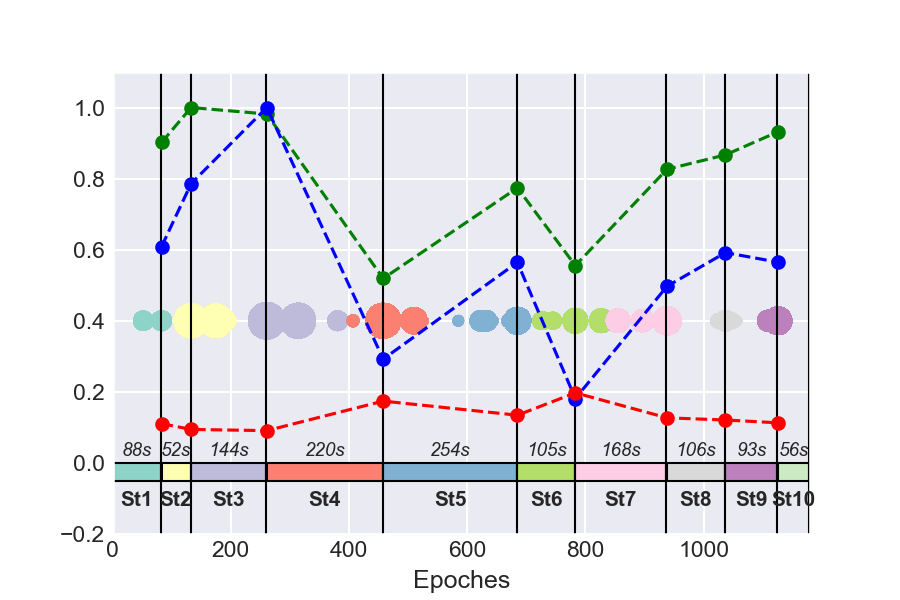

In [120]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca
st_bands, st_labels = spr.form_stage_bands(st_edges_result)
n_stages = len(st_bands)

# Sorting cluster labels for st_edges_all
#edg_labels_all = cluster_method.labels_
labels_uq = sorted(set(edg_labels_all), key=list(edg_labels_all).index)
edg_labels_sort = []
for _cl in range(len(labels_uq)):
    edg_labels_sort += [_cl for i in np.where(edg_labels_all == labels_uq[_cl])[0]]

# Getting time length of the stages
cluster_events = epochs_filt_rr.events.copy() # for m10 and m3
#cluster_events = epochs_filt_rr[:-2].events.copy() # for m8 (artifacts at the end)
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]
print(st_time_len)

# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           facecolor = pal(_st/(n_stages)), fill=True, lw=1)) # for 8 stages
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           #facecolor = pal(_st/(n_stages+1)), fill=True, lw=1)) # for 10 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines
    
    # Background colors
    #ax.axvspan(x_start, x_end, alpha=0.3, color=pal(_st/(n_stages-1)))

    # Scatter plot
    x_sc = [st_edges_all[i] for i in range(len(st_edges_all)) if edg_labels_sort[i]==_st]
    y_sc = np.full(len(x_sc), 0.4)
    s = [1.5*x_sc.count(x_sc[i]) for i in range(len(x_sc))]
    ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages))) # for 8 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages-1))) # for 9 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages+1))) # for 10 stages
    
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.12, st_name, fontsize=10, fontweight='bold', horizontalalignment='center')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    
# Adjacent stage distances (Centroid) & Silh coef 
x_dist = st_edges_result[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centroid distance')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silhouette score')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Davies-Bouldin score')

ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
plt.savefig(subj_dir_name + ' meditation stages.png')

#plt.tight_layout(rect=[-0.01,0.05,1,1])
#handles, labels = ax.get_legend_handles_labels()
#leg = fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=11, handlelength=4)# , mode='expand')


In [122]:
# Getting time length of the stages

st_names =['Stage '+str(i+1) for i in range(n_stages)]
df_st_time_len = pd.DataFrame(columns=['Parameters']+st_names)

time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], 'St'+str(i+1)))

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands[i][0]/sampling_rate), round(time_bands[i][1]/sampling_rate))) 
                      for i in range(n_stages)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands[i][1]-time_bands[i][0])/sampling_rate)) for i in range(n_stages)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands[i][1]-st_bands[i][0]+1) for i in range(n_stages)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

print(time_bands)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands])

display(df_st_time_len)    
df_st_time_len.to_excel(subj_dir_name + ' df_st_time_len.xlsx')


{'Stage 1': 83, 'Stage 2': 50, 'Stage 3': 128, 'Stage 4': 197, 'Stage 5': 227, 'Stage 6': 98, 'Stage 7': 155, 'Stage 8': 99, 'Stage 9': 89, 'Stage 10': 54}
[(4250, 48250, 'St1'), (48750, 74750, 'St2'), (75750, 147750, 'St3'), (148250, 258250, 'St4'), (258750, 385750, 'St5'), (386250, 438750, 'St6'), (439250, 523250, 'St7'), (523750, 576750, 'St8'), (577250, 623750, 'St9'), (624250, 652250, 'St10')]
[(88.0, 'St1'), (52.0, 'St2'), (144.0, 'St3'), (220.0, 'St4'), (254.0, 'St5'), (105.0, 'St6'), (168.0, 'St7'), (106.0, 'St8'), (93.0, 'St9'), (56.0, 'St10')]


Parameters  Stage 1    Stage 2     Stage 3     Stage 4  \
0  Start-end time, sec  (8, 96)  (98, 150)  (152, 296)  (296, 516)   
1     Time length, sec     88.0       52.0       144.0       220.0   
2     Number of epochs       83         50         128         197   

      Stage 5     Stage 6      Stage 7       Stage 8       Stage 9  \
0  (518, 772)  (772, 878)  (878, 1046)  (1048, 1154)  (1154, 1248)   
1       254.0       105.0        168.0         106.0          93.0   
2         227          98          155            99            89   

       Stage 10  
0  (1248, 1304)  
1          56.0  
2            54

In [123]:
# DataFrame with stage distances (by adjacent pairs)

df_features = df_ft_tot_pca

# Forming DataFrame with distance values    
st_dist_names = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages)]
df_st_dist_pairs = pd.DataFrame(columns=['Method'] + st_dist_names)
#display(df_st_dist_pairs)
 
# Ward distances
st_dist_ward_dict = dict([(st_dist_names[i], st_dist_ward[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names[i], st_dist_centr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names[i], st_metr_silh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names[i], st_metr_calh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names[i], st_metr_davb[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

display(df_st_dist_pairs)
df_st_dist_pairs.to_excel(subj_dir_name + ' df_st_dist_pairs.xlsx')

Method  St1_St2   St2_St3   St3_St4  St4_St5   St5_St6  \
0            Ward distance 8,223.48 11,654.64 24,241.19 9,209.06 13,288.74   
1        Centroid distance    16.23     18.00     17.68     9.34     13.93   
2   Silhouette Coefficient     0.12      0.16      0.20     0.06      0.11   
3  Calinski-Harabasz Index    21.16     32.68     82.07    29.04     33.73   
4     Davies-Bouldin Index     2.27      1.94      1.87     3.58      2.76   

   St6_St7   St7_St8   St8_St9  St9_St10  
0 6,003.76 13,367.50 11,414.11  9,459.54  
1    10.00     14.88     15.61     16.78  
2     0.04      0.10      0.12      0.11  
3    13.51     32.18     28.48     22.39  
4     4.06      2.61      2.49      2.32

In [124]:
# DataFrame with averaged cluster distances & metrics

subj_name = subj_dir_name

col_names = ['Subject', 'Center type', 'Ward dist', 'Centr dist', 'Silh Stage', 'Cal-Har Stage', 'Dav-Bold Stage', 
             'Silh Total', 'Cal-Har Total', 'Dav-Bold Total']
df_st_dist_total = pd.DataFrame(columns=col_names)

new_row = {'Subject': subj_name, 'Center type': cl_center_type}
n_pair_metr = len(df_st_dist_pairs)
n_head_col = len(new_row)
n_add_col = len(col_names)-n_head_col-n_pair_metr 

st_metr_val = [df_st_dist_pairs[df_st_dist_pairs.columns[1:]].iloc[r].mean() for r in range(n_pair_metr)]
new_row_add1 = dict([(col_names[r+n_head_col], st_metr_val[r]) for r in range(n_pair_metr)])
new_row.update(new_row_add1)

df = cq.cluster_metrics_noground(subj_name, df_features, st_labels)
new_row_add2 = dict([(col_names[r+n_head_col+n_pair_metr], df[df.columns[r+1]].iloc[0]) for r in range(n_add_col)])
new_row.update(new_row_add2)

df_st_dist_total = df_st_dist_total.append(new_row, ignore_index = True)

display(df_st_dist_total)
df_st_dist_total.to_excel(subj_dir_name + ' df_st_dist_total.xlsx')


Subject Center type  Ward dist  Centr dist  Silh Stage  Cal-Har Stage  \
0   m03_2        mode  11,873.56       14.72        0.11          32.80   

   Dav-Bold Stage  Silh Total  Cal-Har Total  Dav-Bold Total  
0            2.66       -0.02          63.30            4.65

## Surrogate data

[88, 134, 129, 185, 109, 131, 132, 114, 88, 176]


<IPython.core.display.Javascript object>


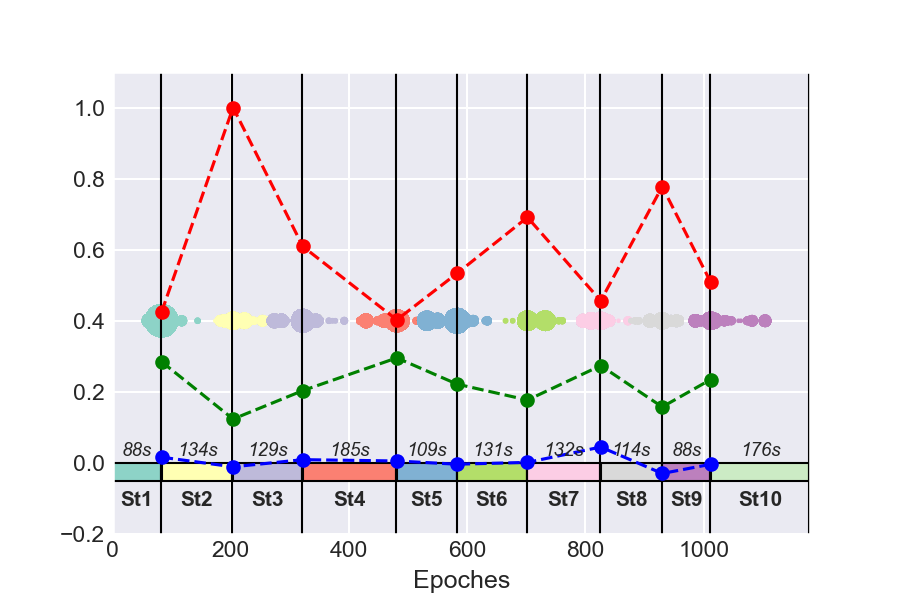

In [126]:
# Plotting stages, distances, silh (Surrogate data)

df_features_surr = df_ft_tot_pca_surr
st_bands_surr, st_labels_surr = spr.form_stage_bands(st_edges_result_surr)
n_stages = len(st_bands_surr)

# Sorting cluster labels for st_edges_all
#edg_labels_all_surr = cluster_method_surr.labels_
labels_uq = sorted(set(edg_labels_all_surr), key=list(edg_labels_all_surr).index)
edg_labels_sort = []
for _cl in range(len(labels_uq)):
    edg_labels_sort += [_cl for i in np.where(edg_labels_all_surr == labels_uq[_cl])[0]]

# Getting time length of the stages
cluster_events_surr = epochs_filt_rr.events.copy() # for m10 & m3
#cluster_events_surr = epochs_filt_rr[:-2].events.copy() # for m8 (artifacts at the end)
cluster_events_surr[:,2] = st_labels_surr
time_bands_surr = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events_surr[:,2] == i)[0]
    time_bands_surr.append((cluster_events_surr[cl_samples[0]][0], cluster_events_surr[cl_samples[-1]][0], st_bands_surr[i][2]))
st_time_len = [round((time_bands_surr[i][1]-time_bands_surr[i][0])/sampling_rate) for i in range(n_stages)]
print(st_time_len)

# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples_surr)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands_surr[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           facecolor = pal(_st/(n_stages)), fill=True, lw=1)) # for 8 stages
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           #facecolor = pal(_st/(n_stages+1)), fill=True, lw=1)) # for 10 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1)), linewidth=1.5) # colored lines
    
    # Background colors
    #ax.axvspan(x_start, x_end, alpha=0.3, color=pal(_st/(n_stages-1)))

    # Scatter plot
    x_sc = [st_edges_all_surr[i] for i in range(len(st_edges_all_surr)) if edg_labels_sort[i]==_st]
    y_sc = np.full(len(x_sc), 0.4)
    s = [1.5*x_sc.count(x_sc[i]) for i in range(len(x_sc))]
    ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages))) # for 8 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages-1))) # for 9 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages+1))) # for 10 stages
    
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.12, st_name, fontsize=10, fontweight='bold', horizontalalignment='center')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    
# Adjacent stage distances (Centroid) & Silh coef 
x_dist = st_edges_result_surr[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr_surr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh_surr]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh_surr]
y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb_surr]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centroid distance')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silhouette metric')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Dav-Bold metric')

ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
plt.savefig(subj_dir_name_surr + ' meditation stages.png')


In [47]:
# Getting time length of the stages

st_names =['Stage '+str(i+1) for i in range(n_stages_surr)]
df_st_time_len_surr = pd.DataFrame(columns=['Parameters']+st_names)

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands_surr[i][0]/sampling_rate), round(time_bands_surr[i][1]/sampling_rate))) 
                      for i in range(n_stages_surr)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len_surr = df_st_time_len_surr.append(new_row, ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands_surr[i][1]-time_bands_surr[i][0])/sampling_rate)) 
                      for i in range(n_stages_surr)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len_surr = df_st_time_len_surr.append(new_row, ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands_surr[i][1]-st_bands_surr[i][0]+1) for i in range(n_stages_surr)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len_surr = df_st_time_len_surr.append(new_row, ignore_index = True)

print(time_bands_surr)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands_surr])

display(df_st_time_len_surr)    
df_st_time_len_surr.to_excel(subj_dir_name_surr + ' df_st_time_len.xlsx')


NameError: name 'time_bands_surr' is not defined

In [64]:
# DataFrame with stage distances (by adjacent pairs)

df_features_surr = df_ft_tot_pca_surr

# Forming DataFrame with distance values    
st_dist_names = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages_surr)]
df_st_dist_pairs_surr = pd.DataFrame(columns=['Method'] + st_dist_names)
#display(df_st_dist_pairs_surr)

# Ward distances
st_dist_ward_dict = dict([(st_dist_names[i], st_dist_ward_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names[i], st_dist_centr_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names[i], st_metr_silh_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names[i], st_metr_calh_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names[i], st_metr_davb_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

display(df_st_dist_pairs_surr)
df_st_dist_pairs_surr.to_excel(subj_dir_name_surr + ' df_st_dist_pairs.xlsx')

Method  St1_St2  St2_St3  St3_St4  St4_St5  St5_St6  \
0            Ward distance 1,293.94   296.12   909.37 1,759.74   875.18   
1        Centroid distance     5.13     2.23     3.66     5.32     3.99   
2   Silhouette Coefficient     0.00    -0.00     0.00     0.00    -0.00   
3  Calinski-Harabasz Index     2.36     0.53     1.61     3.30     1.66   
4     Davies-Bouldin Index     8.73    20.54    12.53     8.28    10.98   

   St6_St7  St7_St8  St8_St9  St9_St10  
0   615.91 1,374.39   369.66    983.05  
1     3.18     4.93     2.84      4.22  
2     0.00     0.01    -0.01     -0.00  
3     1.11     2.41     0.66      1.84  
4    14.22     9.39    15.98     10.46

In [128]:
# DataFrame with stage distances (by adjacent pairs)

df_features_surr = df_ft_tot_pca_surr

# Forming DataFrame with distance values    
st_dist_names = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages_surr)]
df_st_dist_pairs_surr = pd.DataFrame(columns=['Method'] + st_dist_names)
#display(df_st_dist_pairs_surr)

# Ward distances
st_dist_ward_dict = dict([(st_dist_names[i], st_dist_ward_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names[i], st_dist_centr_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names[i], st_metr_silh_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names[i], st_metr_calh_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names[i], st_metr_davb_surr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs_surr = df_st_dist_pairs_surr.append(new_row, ignore_index = True)

display(df_st_dist_pairs_surr)
df_st_dist_pairs_surr.to_excel(subj_dir_name_surr + ' df_st_dist_pairs.xlsx')

Method  St1_St2  St2_St3  St3_St4  St4_St5  St5_St6  \
0            Ward distance 1,294.30   295.18   909.44 1,759.78   875.11   
1        Centroid distance     5.13     2.22     3.66     5.32     3.99   
2   Silhouette Coefficient     0.00    -0.00     0.00     0.00    -0.00   
3  Calinski-Harabasz Index     2.36     0.52     1.61     3.30     1.66   
4     Davies-Bouldin Index     8.73    20.57    12.53     8.28    10.98   

   St6_St7  St7_St8  St8_St9  St9_St10  
0   615.84 1,373.98   368.94    982.91  
1     3.18     4.93     2.84      4.22  
2     0.00     0.01    -0.01     -0.00  
3     1.11     2.41     0.66      1.84  
4    14.22     9.39    16.00     10.47

In [129]:
# DataFrame with averaged cluster distances & metrics (Surrogate data)

subj_name = 'pseudo-'+subj_dir_name

col_names = ['Subject', 'Center type', 'Ward dist', 'Centr dist', 'Silh Stage', 'Cal-Har Stage', 'Dav-Bold Stage', 
             'Silh Total', 'Cal-Har Total', 'Dav-Bold Total']
df_st_dist_total_surr = pd.DataFrame(columns=col_names)

new_row = {'Subject': subj_name, 'Center type': cl_center_type_surr}
n_head_col = len(new_row)
n_pair_metr = len(df_st_dist_pairs_surr)
n_add_col = len(col_names)-n_head_col-n_pair_metr 

st_metr_val = [df_st_dist_pairs_surr[df_st_dist_pairs_surr.columns[1:]].iloc[r].mean() for r in range(n_pair_metr)]
new_row_add1 = dict([(col_names[r+n_head_col], st_metr_val[r]) for r in range(n_pair_metr)])
new_row.update(new_row_add1)

df = cq.cluster_metrics_noground(subj_name, df_features_surr, st_labels_surr)
new_row_add2 = dict([(col_names[r+n_head_col+n_pair_metr], df[df.columns[r+1]].iloc[0]) for r in range(n_add_col)])
new_row.update(new_row_add2)

df_st_dist_total_surr = df_st_dist_total_surr.append(new_row, ignore_index = True)

#df_st_dist_total = pd.concat([df_st_dist_total, df_st_dist_total_surr], ignore_index=True)

display(df_st_dist_total_surr)
df_st_dist_total_surr.to_excel(subj_dir_name_surr + ' df_st_dist_total.xlsx')


Subject Center type  Ward dist  Centr dist  Silh Stage  Cal-Har Stage  \
0  pseudo-m03_2        mode     941.72        3.94        0.00           1.72   

   Dav-Bold Stage  Silh Total  Cal-Har Total  Dav-Bold Total  
0           12.35       -0.05           1.63           22.13

# Save results

In [130]:
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # for m10
print(st_edges_result)

[0, 83, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180]


In [131]:
#st_edges_result_surr = [0, 133, 241, 313, 417, 570, 636, 759, 891, 1034] # for m10_surr
print(st_edges_result_surr)

[0, 83, 204, 322, 481, 583, 702, 826, 930, 1012, 1180]


In [132]:
# Boundary epochs sample numbers and times
st_edges_res_samp = epochs_filt_rr[st_edges_result[:-1]].events[:,0]
print(st_edges_res_samp)
print(st_edges_result[:-1])


[  4250  48750  75750 148250 258750 386250 439250 523750 577250 624250]
[0, 83, 133, 261, 458, 685, 783, 938, 1037, 1126]


In [133]:
# Save clusterization results

# Boundary epochs sample numbers and times
st_edges_res_samp = epochs_filt_rr[st_edges_result[:-1]].events[:,0]
print(st_edges_res_samp)
print(st_edges_result[:-1])
print()

# Clusterization
#df_st_edges.to_feather(os.path.join(ft_dir_path, 'df_st_edges.feather'))
#df_st_edges = pd.read_feather(os.path.join(ft_root_path, 'df_st_edges.feather'))

# Main data
np.savetxt(os.path.join(ft_dir_path, 'st_edges_result.txt'), st_edges_result) # Stage boundaries
np.savetxt(os.path.join(ft_dir_path, 'st_edges_res_samp.txt'), st_edges_res_samp)  # Stage boundary times*sampling_rate

# Surrogate data
np.savetxt(os.path.join(ft_dir_path, 'st_edges_result_surr.txt'), st_edges_result_surr) # Stage boundaries
np.savetxt(os.path.join(ft_dir_path, 'shuffled_index_order.txt'), shuf_piece_ind)  # Shuffling order

print(st_edges_result)
print(st_edges_res_samp)
print(st_edges_result_surr)

[  4250  48750  75750 148250 258750 386250 439250 523750 577250 624250]
[0, 83, 133, 261, 458, 685, 783, 938, 1037, 1126]

[0, 83, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180]
[  4250  48750  75750 148250 258750 386250 439250 523750 577250 624250]
[0, 83, 204, 322, 481, 583, 702, 826, 930, 1012, 1180]


## DBSCAN

In [101]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']

eps_coef_list = [0.02, 0.025, 0.03]
min_samp_coef = 0.02
n_st_edge_max = 15

df_features = df_ft_tot_pca

df_st_edge_metr_dbs = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metr_dbs = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_res_dbs = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Eps_coef', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all = []
            st_edges_list = []
            st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                              (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all += _st_edges[1:-1].tolist()
            st_edges_all = sorted(st_edges_all)
            print(st_len, k_nb_max, n_cl, len(st_edges_all))
            df_st_edges_all = pd.DataFrame(st_edges_all)
            
            # Clustering stage edges
            for eps_coef in eps_coef_list:
                cl_name = ('dbscan_edges_'+str(eps_coef)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                cluster_method, df_st_edge_metr_dbs = cq.apply_cluster_method(data=df_st_edges_all, cl_method=DBSCAN, 
                                                                    name=cl_name, df_metrics=df_st_edge_metr_dbs, 
                                                                    eps=eps_coef*n_samples, 
                                                                    min_samples=int(min_samp_coef*len(st_edges_all)))
                n_st_edge_clusters = len([cl for cl in np.unique(cluster_method.labels_) if cl>=0])
                
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode[0])
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    st_edges_result = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    st_bands, new_labels = spr.form_stage_bands(st_edges_result, n_samples)
                    n_stages = len(st_bands)
                
                    name = ('stages_'+cl_cen+'_'+str(eps_coef)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                   
                    # Overall dataset clustering metrics for stages
                    df = cq.cluster_metrics_noground(name, df_features, new_labels)
                    df_stage_metr_dbs = df_stage_metr_dbs.drop(df_stage_metr_dbs[df_stage_metr_dbs['Method']==name].index, 
                                                               errors='ignore')
                    df_stage_metr_dbs = pd.concat([df_stage_metr_dbs, df], ignore_index=True)
                                                
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
                    silh = df_adj_st_metr['Silh'].mean()
                    cal_har = df_adj_st_metr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                               'N_cl_max': n_cl, 'Eps_coef': eps_coef*100, 'Cl_cen': cl_cen, 
                               'Ward_dist': st_dist_w_avg[_cen], 'Cen_dist': st_dist_c_avg[_cen], 
                               'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold, 'St_edges': st_edges_result}
                    df_st_edges_res_dbs = df_st_edges_res_dbs.append(new_row, ignore_index = True)
                            
pd.set_option('display.max_rows', None)
display(df_st_edge_metr_dbs)
display(df_stage_metr_dbs)
display(df_st_edges_res_dbs)        


0 35 10 1068
0 35 15 2160
0 35 20 3698
0 40 10 1378
0 40 15 2748
0 40 20 4734
0 45 10 1671
0 45 15 3316
0 45 20 5675
0 50 10 1968
0 50 15 3885
0 50 20 6694
20 35 10 987
20 35 15 1929
20 35 20 2966
20 40 10 1266
20 40 15 2452
20 40 20 3756
20 45 10 1522
20 45 15 2942
20 45 20 4507
20 50 10 1790
20 50 15 3435
20 50 20 5226
40 35 10 904
40 35 15 1688
40 35 20 2526
40 40 10 1177
40 40 15 2189
40 40 20 3268
40 45 10 1429
40 45 15 2655
40 45 20 3959
40 50 10 1697
40 50 15 3146
40 50 20 4675
60 35 10 824
60 35 15 1475
60 35 20 2143
60 40 10 1074
60 40 15 1942
60 40 20 2830
60 45 10 1316
60 45 15 2398
60 45 20 3511
60 50 10 1569
60 50 15 2872
60 50 20 4210


Method  Silh    Cal-Har  Dav-Bold
0      dbscan_edges_0.02_0_35_10  0.80   1,923.43      1.29
1     dbscan_edges_0.025_0_35_10  0.78   2,196.45      1.39
2      dbscan_edges_0.03_0_35_10  0.73   2,545.48      1.34
3      dbscan_edges_0.02_0_35_15  0.80   6,431.42      0.80
4     dbscan_edges_0.025_0_35_15  0.75  10,911.40      3.19
5      dbscan_edges_0.03_0_35_15  0.73  11,081.55      5.47
6      dbscan_edges_0.02_0_35_20  0.74   7,560.45      1.38
7     dbscan_edges_0.025_0_35_20  0.72  13,095.17      3.66
8      dbscan_edges_0.03_0_35_20  0.56  11,269.19      2.70
9      dbscan_edges_0.02_0_40_10  0.80   2,108.40      1.31
10    dbscan_edges_0.025_0_40_10  0.81   2,691.36      2.49
11     dbscan_edges_0.03_0_40_10  0.73   2,879.17      1.96
12     dbscan_edges_0.02_0_40_15  0.81   7,041.92      1.28
13    dbscan_edges_0.025_0_40_15  0.76  13,885.90      2.78
14     dbscan_edges_0.03_0_40_15  0.74  14,086.91      2.68
15     dbscan_edges_0.02_0_40_20  0.77   7,835.97     27.47
16    dbscan_edges_0.025_0_40_20  0.73  15,541.33      4.44
17     dbscan_edges_0.03_0_40_20  0.67  13,569.02      5.84
18     dbscan_edges_0.02_0_45_10  0.80   2,237.94      1.58
19    dbscan_edges_0.025_0_45_10  0.82   2,859.66      3.45
20     dbscan_edges_0.03_0_45_10  0.74   3,069.32      2.43
21     dbscan_edges_0.02_0_45_15  0.79   6,684.45      3.73
22    dbscan_edges_0.025_0_45_15  0.79  13,639.20      2.76
23     dbscan_edges_0.03_0_45_15  0.74  14,911.39      2.82
24     dbscan_edges_0.02_0_45_20  0.75   9,133.70     58.76
25    dbscan_edges_0.025_0_45_20  0.74  17,712.65      3.73
26     dbscan_edges_0.03_0_45_20  0.67  15,555.06      4.89
27     dbscan_edges_0.02_0_50_10  0.79   2,736.54      2.09
28    dbscan_edges_0.025_0_50_10  0.80   3,640.43     11.60
29     dbscan_edges_0.03_0_50_10  0.77   3,975.80      2.78
30     dbscan_edges_0.02_0_50_15  0.78   9,341.02      4.65
31    dbscan_edges_0.025_0_50_15  0.79  17,535.27      2.94
32     dbscan_edges_0.03_0_50_15  0.75  19,029.47      3.11
33     dbscan_edges_0.02_0_50_20  0.75  11,344.09      1.84
34    dbscan_edges_0.025_0_50_20  0.75  20,341.72      3.41
35     dbscan_edges_0.03_0_50_20  0.67  18,034.96      4.63
36    dbscan_edges_0.02_20_35_10  0.83   3,888.70      1.37
37   dbscan_edges_0.025_20_35_10  0.81   4,076.60      3.26
38    dbscan_edges_0.03_20_35_10  0.75   4,401.18      3.58
39    dbscan_edges_0.02_20_35_15  0.83   8,222.04      0.92
40   dbscan_edges_0.025_20_35_15  0.82  23,481.71      1.56
41    dbscan_edges_0.03_20_35_15  0.74  19,707.72      1.17
42    dbscan_edges_0.02_20_35_20  0.83  34,189.07      1.08
43   dbscan_edges_0.025_20_35_20  0.76  39,907.65      0.61
44    dbscan_edges_0.03_20_35_20  0.61  16,774.28      0.60
45    dbscan_edges_0.02_20_40_10  0.82   2,723.59      1.66
46   dbscan_edges_0.025_20_40_10  0.83   3,287.23      1.82
47    dbscan_edges_0.03_20_40_10  0.75   3,461.45      1.79
48    dbscan_edges_0.02_20_40_15  0.83   7,805.03      1.50
49   dbscan_edges_0.025_20_40_15  0.81  26,921.11      4.29
50    dbscan_edges_0.03_20_40_15  0.75  23,789.91      4.94
51    dbscan_edges_0.02_20_40_20  0.83  13,125.65      1.24
52   dbscan_edges_0.025_20_40_20  0.80  33,781.02      3.24
53    dbscan_edges_0.03_20_40_20  0.63  18,087.25     11.40
54    dbscan_edges_0.02_20_45_10  0.82   2,649.61      1.49
55   dbscan_edges_0.025_20_45_10  0.84   3,383.65      3.53
56    dbscan_edges_0.03_20_45_10  0.75   3,582.43      2.54
57    dbscan_edges_0.02_20_45_15  0.81   6,644.83      4.74
58   dbscan_edges_0.025_20_45_15  0.81  31,294.36      1.68
59    dbscan_edges_0.03_20_45_15  0.75  28,006.42      1.96
60    dbscan_edges_0.02_20_45_20  0.81  12,499.62     23.01
61   dbscan_edges_0.025_20_45_20  0.80  27,591.06     81.95
62    dbscan_edges_0.03_20_45_20  0.62  18,161.45      4.77
63    dbscan_edges_0.02_20_50_10  0.81   3,432.71      4.32
64   dbscan_edges_0.025_20_50_10  0.82   4,907.52      4.37
65    dbscan_edges_0.03_20_50_10  0.79   5,249.68      7.61
66    

Method  Silh  Cal-Har  Dav-Bold
0       stages_med_0.02_0_35_10  0.05    70.70      2.93
1      stages_mode_0.02_0_35_10  0.04    68.80      2.97
2      stages_mean_0.02_0_35_10  0.04    68.12      3.01
3      stages_med_0.025_0_35_10  0.05    75.03      2.98
4     stages_mode_0.025_0_35_10  0.04    72.20      3.03
5     stages_mean_0.025_0_35_10  0.04    68.47      2.92
6       stages_med_0.03_0_35_10  0.04    79.60      3.27
7      stages_mode_0.03_0_35_10  0.04    79.23      3.23
8      stages_mean_0.03_0_35_10  0.04    66.84      3.73
9       stages_med_0.02_0_35_15  0.04    68.30      2.84
10     stages_mode_0.02_0_35_15  0.04    66.32      2.88
11     stages_mean_0.02_0_35_15  0.04    65.92      2.91
12     stages_med_0.025_0_35_15  0.04    78.73      2.85
13    stages_mode_0.025_0_35_15  0.04    78.01      2.96
14    stages_mean_0.025_0_35_15  0.05    73.70      2.76
15      stages_med_0.03_0_35_15  0.04    80.86      2.96
16     stages_mode_0.03_0_35_15  0.04    79.91      3.09
17     stages_mean_0.03_0_35_15  0.05    70.16      2.90
18      stages_med_0.02_0_35_20  0.04    72.02      2.82
19     stages_mode_0.02_0_35_20  0.03    70.20      2.74
20     stages_mean_0.02_0_35_20  0.04    64.86      2.80
21     stages_med_0.025_0_35_20  0.04    79.14      2.84
22    stages_mode_0.025_0_35_20  0.03    76.79      2.86
23    stages_mean_0.025_0_35_20  0.04    71.97      2.77
24      stages_med_0.03_0_35_20  0.06    73.65      3.02
25     stages_mode_0.03_0_35_20  0.05    87.53      2.44
26     stages_mean_0.03_0_35_20  0.06    73.88      2.99
27      stages_med_0.02_0_40_10  0.05    71.98      2.93
28     stages_mode_0.02_0_40_10  0.05    71.94      2.95
29     stages_mean_0.02_0_40_10  0.04    67.90      3.00
30     stages_med_0.025_0_40_10  0.04    78.45      3.06
31    stages_mode_0.025_0_40_10  0.04    78.14      3.08
32    stages_mean_0.025_0_40_10  0.04    71.39      3.00
33      stages_med_0.03_0_40_10  0.04    79.81      3.24
34     stages_mode_0.03_0_40_10  0.04    79.96      3.23
35     stages_mean_0.03_0_40_10  0.04    66.98      3.75
36      stages_med_0.02_0_40_15  0.04    69.82      2.82
37     stages_mode_0.02_0_40_15  0.03    66.95      2.76
38     stages_mean_0.02_0_40_15  0.04    66.12      2.90
39     stages_med_0.025_0_40_15  0.04    79.14      2.84
40    stages_mode_0.025_0_40_15  0.03    77.40      2.89
41    stages_mean_0.025_0_40_15  0.05    74.98      2.76
42      stages_med_0.03_0_40_15  0.04    80.92      2.96
43     stages_mode_0.03_0_40_15  0.03    79.27      2.99
44     stages_mean_0.03_0_40_15  0.05    71.34      2.91
45      stages_med_0.02_0_40_20  0.04    69.82      2.82
46     stages_mode_0.02_0_40_20  0.03    67.90      2.72
47     stages_mean_0.02_0_40_20  0.04    65.58      2.93
48     stages_med_0.025_0_40_20  0.05    84.35      2.91
49    stages_mode_0.025_0_40_20  0.04    83.05      2.88
50    stages_mean_0.025_0_40_20  0.05    77.52      2.84
51      stages_med_0.03_0_40_20  0.07    79.34      3.21
52     stages_mode_0.03_0_40_20  0.01    72.42      2.37
53     stages_mean_0.03_0_40_20  0.08    80.40      3.19
54      stages_med_0.02_0_45_10  0.05    72.24      2.93
55     stages_mode_0.02_0_45_10  0.05    71.94      2.95
56     stages_mean_0.02_0_45_10  0.04    67.71      3.01
57     stages_med_0.025_0_45_10  0.04    78.23      3.05
58    stages_mode_0.025_0_45_10  0.04    78.14      3.08
59    stages_mean_0.025_0_45_10  0.04    71.14      3.00
60      stages_med_0.03_0_45_10  0.04    79.58      3.23
61     stages_mode_0.03_0_45_10  0.04    79.96      3.23
62     stages_mean_0.03_0_45_10  0.04    67.02      3.73
63      stages_med_0.02_0_45_15  0.04    71.85      2.83
64     stages_mode_0.02_0_45_15  0.03    70.12      2.84
65     stages_mean_0.02_0_45_15  0.04    66.35      2.79
66     stages_med_0.025_0_45_15  0.04    75.23      2.93
67    stages_mode_0.025_0_45_15  0.02    71.96      2.88
68    stages_mean_0.025_0_45_15  0.04    69.02      2.89
69      stages_med_0.03_0_45_15  0.

N_stages St_len_min K_nb_max N_cl_max  Eps_coef Cl_cen  Ward_dist  \
0         12          0       35       10      2.00    med  15,062.00   
1         12          0       35       10      2.00   mode  14,313.49   
2         12          0       35       10      2.00   mean  14,569.46   
3         11          0       35       10      2.50    med  17,240.09   
4         11          0       35       10      2.50   mode  16,202.75   
5         11          0       35       10      2.50   mean  15,450.70   
6          9          0       35       10      3.00    med  20,791.81   
7          9          0       35       10      3.00   mode  21,221.49   
8          9          0       35       10      3.00   mean  17,147.06   
9         13          0       35       15      2.00    med  14,087.71   
10        13          0       35       15      2.00   mode  13,482.48   
11        13          0       35       15      2.00   mean  13,688.72   
12        10          0       35       15      2.50    med  20,438.52   
13        10          0       35       15      2.50   mode  19,842.37   
14        10          0       35       15      2.50   mean  18,891.45   
15         9          0       35       15      3.00    med  23,581.60   
16         9          0       35       15      3.00   mode  23,021.56   
17         9          0       35       15      3.00   mean  19,707.97   
18        12          0       35       20      2.00    med  16,121.01   
19        12          0       35       20      2.00   mode  15,695.39   
20        12          0       35       20      2.00   mean  14,097.38   
21        10          0       35       20      2.50    med  20,577.96   
22        10          0       35       20      2.50   mode  20,333.79   
23        10          0       35       20      2.50   mean  18,335.77   
24         7          0       35       20      3.00    med  25,458.92   
25         7          0       35       20      3.00   mode  29,464.15   
26         7          0       35       20      3.00   mean  24,873.50   
27        12          0       40       10      2.00    med  15,356.68   
28        12          0       40       10      2.00   mode  15,361.84   
29        12          0       40       10      2.00   mean  14,462.32   
30        10          0       40       10      2.50    med  19,657.25   
31        10          0       40       10      2.50   mode  20,223.00   
32        10          0       40       10      2.50   mean  17,619.72   
33         9          0       40       10      3.00    med  21,427.96   
34         9          0       40       10      3.00   mode  22,359.98   
35         9          0       40       10      3.00   mean  17,261.14   
36        13          0       40       15      2.00    med  14,498.32   
37        13          0       40       15      2.00   mode  13,679.56   
38        13          0       40       15      2.00   mean  13,702.07   
39        10          0       40       15      2.50    med  20,577.96   
40        10          0       40       15      2.50   mode  20,526.97   
41        10          0       40       15      2.50   mean  19,263.03   
42         9          0       40       15      3.00    med  23,650.76   
43         9          0       40       15      3.00   mode  23,775.63   
44         9          0       40       15      3.00   mean  20,188.47   
45        13          0       40       20      2.00    med  14,498.32   
46        13          0       40       20      2.00   mode  14,116.48   
47        13          0       40       20      2.00   mean  13,611.78   
48         9          0       40       20      2.50    med  23,443.48   
49         9          0       40       20      2.50   mode  25,111.00   
50         9          0       40       20      2.50   mean  21,172.96   
51         6          0       40       20      3.00    med  31,519.49   
52         6          0       40       20      3.00   mode  30,515.72   
53         6          0       40       20      3.00   mean  31

In [102]:
# Plot parameters for each number of stages

df_st_edges_best_dbs = pd.DataFrame(columns=df_st_edges_res_dbs.columns)

for n_st in set(df_st_edges_res_dbs['N_stages']):
    df = df_st_edges_res_dbs[(df_st_edges_res_dbs['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]
       
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best_dbs = df_st_edges_best_dbs.append(new_row, ignore_index = True)
    
display(df_st_edges_best_dbs)

N_stages St_len_min K_nb_max N_cl_max  Eps_coef Cl_cen  Ward_dist  Cen_dist  \
0        6          0       50       20      3.00   mode  33,707.39     22.30   
1        7          0       35       20      3.00   mode  29,464.15     21.03   
2        8         20       45       20      3.00    med  29,308.15     21.95   
3        9          0       45       20      2.50   mode  25,138.85     21.80   
4       10         40       50       20      2.50   mode  20,702.45     20.99   
5       11         20       50       20      2.50   mode  18,270.44     20.25   
6       12         20       50       20      2.00   mode  16,292.61     19.67   
7       13         20       40       20      2.00   mode  14,440.94     19.51   

   Silh  Cal-Har  Dav-Bold                                           St_edges  
0  0.20    86.89      1.68                  [0, 92, 560, 666, 784, 857, 1046]  
1  0.19    82.67      1.72             [0, 39, 237, 560, 666, 784, 857, 1046]  
2  0.21    80.13      1.64        [0, 39, 163, 555, 681, 784, 857, 972, 1046]  
3  0.20    71.01      1.64   [0, 39, 282, 492, 560, 666, 784, 857, 976, 1046]  
4  0.21    63.33      1.75  [0, 92, 263, 492, 560, 607, 681, 784, 857, 976...  
5  0.20    57.46      1.74  [0, 39, 92, 282, 492, 560, 607, 681, 784, 857,...  
6  0.20    52.25      1.81  [0, 39, 92, 154, 282, 492, 560, 607, 681, 784,...  
7  0.20    47.55      1.85  [0, 39, 95, 154, 237, 492, 560, 607, 682, 784,...

[0, 39, 282, 492, 560, 666, 784, 857, 976, 1046]


<IPython.core.display.Javascript object>


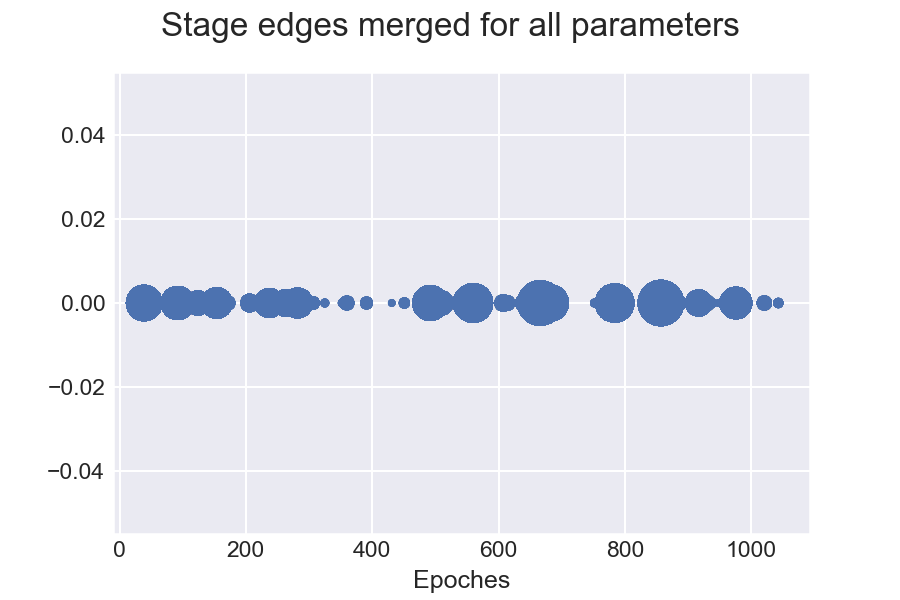

<IPython.core.display.Javascript object>


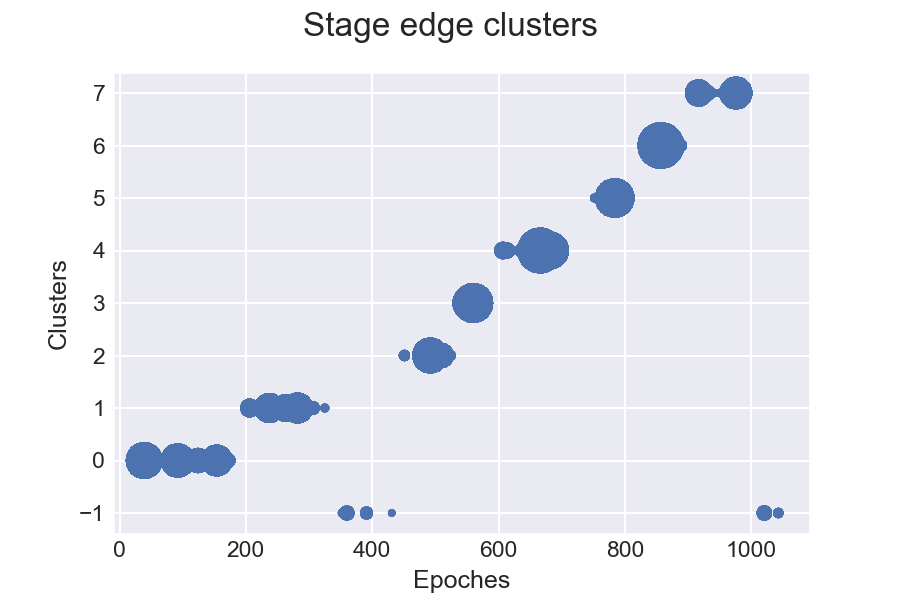

In [104]:
# Clustering parameters k_neighb_max=40, silh_metric_threshold = 0.05

n_stages = 9 # expert choise of result number of stages
df_st_edges_best = df_st_edges_best_dbs

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl= df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]
eps_coef =  df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['Eps_coef'].iloc[0]/100.


st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'dbscan_edges_'+str(n_stages)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=DBSCAN, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            eps=eps_coef*n_samples, 
                                                            min_samples=int(min_samp_coef*len(st_edges_all)))
edg_labels_all = cluster_method.labels_

# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.2*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
plt.savefig('Stage edges merged.png')

# Plotting clusters    
x = st_edges_all
y = cluster_method.labels_
s = [1.2*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
plt.savefig('Stage edge clusters.png')


In [39]:
# Test

df=df_st_edges_result[df_st_edges_result['N_stages']==9]
df1 = df[(df['Silh']>0.195) & (df['Cen_dist']>21)]
display(df1)
print(df1['Silh'].to_numpy())
silh_max = df['Silh'].max()
display(df[df['Silh']==silh_max])

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
187        9          0       40       15   mode  24,093.62     21.01  0.20   
229        9          0       40       20   mode  25,109.49     21.64  0.20   
313        9          0       45       15   mode  24,093.62     21.01  0.20   
439        9          0       50       15   mode  24,172.99     21.09  0.20   

     Cal-Har  Dav-Bold                                          St_edges  
187    68.14      1.74  [0, 92, 282, 490, 560, 666, 784, 857, 976, 1046]  
229    71.11      1.65  [0, 39, 237, 492, 560, 666, 784, 857, 976, 1046]  
313    68.14      1.74  [0, 92, 282, 490, 560, 666, 784, 857, 976, 1046]  
439    68.51      1.73  [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046]

[0.19773357 0.20080222 0.19773357 0.19934837]


N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
229        9          0       40       20   mode  25,109.49     21.64  0.20   

     Cal-Har  Dav-Bold                                          St_edges  
229    71.11      1.65  [0, 39, 237, 492, 560, 666, 784, 857, 976, 1046]